# Analysis of generated paths 

In [1]:
import json
import os
from typing import List, Dict, Any, Tuple, Optional

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib import rcParams
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MaxNLocator
from seaborn import color_palette

# import for data analysis
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats

import plotly.express as px
import plotly.graph_objects as go

from tqdm import tqdm
import re

In [2]:
def load_input(file_path: str) -> Dict:
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

def load_all_results(results_dir: str) -> Dict:
    all_results = {}
    for file in tqdm(os.listdir(results_dir), total=len(os.listdir(results_dir))):
        if file.endswith(".json"):
            file_path = os.path.join(results_dir, file)
            data = load_input(file_path)
            all_results[file] = data
    return all_results


a = load_input("samples/final_predictions/SQA/intermediate_results_cmdr_ic=2/model=command-r_execmode=trace_prompt=standard_process=0_icl=2_output.json")
b = load_all_results("samples/final_predictions/SQA/intermediate_results_cmdr_ic=2/")

100%|██████████| 33/33 [00:00<00:00, 770.45it/s]


In [3]:
# samples_per_file = load_all_results("samples/final_predictions/SQA")
samples_per_file = load_all_results("samples/final_predictions/gsm8k")

100%|██████████| 23/23 [00:00<00:00, 71.31it/s]


In [4]:
samples_per_file.keys()
    

dict_keys(['model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json', 'model=gpt-3.5-turbo_execmode=plan_only_prompt=standard_icl=8_output.json', 'model=Meta-Llama-3-8B_execmode=trace_prompt=standard_icl=1_output.json', 'model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=2_output.json', 'model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json', 'model=command-r-plus_execmode=plan_only_prompt=standard_icl=8_output.json', 'model=command-r_execmode=trace_prompt=standard_icl=6_output.json', 'model=command-r_execmode=plan_only_prompt=standard_icl=6_output.json', 'model=Meta-Llama-3-8B_execmode=trace_prompt=standard_icl=2_output.json', 'model=Mixtral-8x7B-v0.1_execmode=trace_prompt=standard_icl=2_output.json', 'model=command-r_execmode=trace_prompt=standard_icl=8_output.json', 'model=gpt-3.5-turbo_execmode=plan_only_prompt=standard_icl=6_output.json', 'model=command-r-plus_execmode=plan_only_prompt=standard_icl=6_output.json', 'model=command-r-plus_execmode=tr

In [5]:
def get_facts_predicates(trace:str) -> List[Tuple[str,str,Optional[str]]]:
    re_facts = re.compile(r'(\w+)\(([^)]+)\)')
    facts = re_facts.findall(trace)
    # facts = clear_numberd_facts_predicates(facts)
    return facts

def clear_numberd_facts_predicates(facts:List[Tuple[str,str,Optional[str]]]) -> List[Tuple[str,str,Optional[str]]]:
    cleared_facts = []
    for fact in facts:
        toup = []
        for elem in fact: 
            if elem.isdigit():
                continue
            else:
                toup.append(elem)
        cleared_facts.append(tuple(toup))
    return cleared_facts

print(samples_per_file['model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json'][1]['trace'])
print(get_facts_predicates(samples_per_file['model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json'][1]['trace']))
print(samples_per_file['model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json'][1]['code'])
print(get_facts_predicates(samples_per_file['model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json'][1]['code']))
# print(a[1]['trace'])
# print(get_facts_predicates(a[1]['trace']))
# print(a[1]['code'])
# print(get_facts_predicates(a[1]['code']))

def get_assumed_atoms(code : str) -> List[str]:
    assumed_atoms = []
    for line in code.split("\n"):
        if " assumed" in line.lower():
            assumed_atoms.append(line)
    return assumed_atoms

def analyze_trace_and_code(trace:str, code:str, verbose:bool=False) -> Dict:
    
    predicates_fact_trace = get_facts_predicates(trace)
    predicates_fact_code = get_facts_predicates(code)

    predicates_trace = [atom[0] for atom in predicates_fact_trace]
    predicates_code = [atom[0] for atom in predicates_fact_code]
    facts_trace = [atom[1:] for atom in predicates_fact_trace]
    facts_code = [atom[1:] for atom in predicates_fact_code]

    facts_trace = [item for sublist in facts_trace for item in sublist]
    facts_code = [item for sublist in facts_code for item in sublist]

    overlap_predicates = set(predicates_trace) & set(predicates_code)
    overlap_facts = set(facts_trace) & set(facts_code)
    overlap_predicates_facts = set(predicates_fact_trace) & set(predicates_fact_code)

    unique_predicates_trace = set(predicates_trace) - set(predicates_code)
    unique_predicates_code = set(predicates_code) - set(predicates_trace)

    unique_facts_trace = set(facts_trace) - set(facts_code)
    unique_facts_code = set(facts_code) - set(facts_trace)
        
    unique_predicates_facts_trace = set(predicates_fact_trace) - set(predicates_fact_code)
    unique_predicates_facts_code = set(predicates_fact_code) - set(predicates_fact_trace) 

    eps = 1e-6

    ratio_overlap_predicates = len(overlap_predicates) / max(len(predicates_code),1) 
    ratio_overlap_facts = len(overlap_facts) / max(len(facts_code),1)
    ratio_overlap_predicates_facts = len(overlap_predicates_facts) / max(len(predicates_fact_code),1)

    ratio_unique_predicates_trace = len(unique_predicates_trace) / max(len(predicates_trace),1)
    ratio_unique_predicates_code = len(unique_predicates_code) / max(len(predicates_code),1)
    ratio_unique_facts_trace = len(unique_facts_trace) / max(len(facts_trace),1)
    ratio_unique_facts_code = len(unique_facts_code) / max(len(facts_code),1)
    ratio_unique_predicates_facts_trace = len(unique_predicates_facts_trace) / max(len(predicates_fact_trace),1)
    ratio_unique_predicates_facts_code = len(unique_predicates_facts_code) / max(len(predicates_fact_code),1)

    #__________________________________

    attempted_variable_substitutions = []
    for atom in predicates_fact_trace:
        for fact in atom[1:]:
            if fact.startswith("Candidate"):
                attempted_variable_substitutions.append(atom)
    

    assumed_atoms_code = get_assumed_atoms(code)

    predicate_fact_assumed_atoms_code = get_facts_predicates("\n".join(assumed_atoms_code))
    predicates_assumed_atoms_code = [atom[0] for atom in predicate_fact_assumed_atoms_code]
    facts_assumed_atoms_code = [atom[1:] for atom in predicate_fact_assumed_atoms_code]
    facts_assumed_atoms_code = [item for sublist in facts_assumed_atoms_code for item in sublist]

    overlap_predicates_assumed_atoms = set(predicates_trace) & set(predicates_assumed_atoms_code)
    overlap_facts_assumed_atoms = set(facts_trace) & set(facts_assumed_atoms_code)
    overlap_predicates_facts_assumed_atoms = set(predicates_fact_trace) & set(predicate_fact_assumed_atoms_code)

    ratio_overlap_predicates_assumed_atoms = len(overlap_predicates_assumed_atoms) / max(len(predicates_code),1)
    ratio_overlap_facts_assumed_atoms = len(overlap_facts_assumed_atoms) / max(len(facts_code),1)
    ratio_overlap_predicates_facts_assumed_atoms = len(overlap_predicates_facts_assumed_atoms) / max(len(predicates_fact_code),1)

    if verbose:
        print("Overlap of predicates in trace and code: ", overlap_predicates)
        print("Overlap of facts in trace and code: ", overlap_facts)
        print("Unique predicates in trace: ", unique_predicates_trace)
        print("Unique predicates in code: ", unique_predicates_code)
        print("Unique facts in trace: ", unique_facts_trace)
        print("Unique facts in code: ", unique_facts_code)
        print("Unique predicate fact combinations in trace: ", unique_predicates_facts_trace)
        print("Unique predicate fact combinations in code: ", unique_predicates_facts_code)  
        print("Attempted variable substitutions in trace: ", attempted_variable_substitutions)
        print("Assumed atoms in code: ", assumed_atoms_code)
        print("Overlap of predicates in trace and assumed atoms in code: ", overlap_predicates_assumed_atoms)
        print("Overlap of facts in trace and assumed atoms in code: ", overlap_facts_assumed_atoms)

    mata_info = {
        'total_predicate_fact_combinations_trace': len(predicates_fact_trace),
        'total_predicate_fact_combinations_code': len(predicates_fact_code),
        'total_predicates_trace': len(predicates_trace),
        'total_predicates_code': len(predicates_code),
        'total_facts_trace': len(facts_trace),
        'total_facts_code': len(facts_code),
        'overlap_predicates': len(overlap_predicates),
        'overlap_facts': len(overlap_facts),
        'overlap_predicates_facts': len(overlap_predicates_facts),
        'unique_predicates_trace': len(unique_predicates_trace),
        'unique_predicates_code': len(unique_predicates_code),
        'unique_facts_trace': len(unique_facts_trace),
        'unique_facts_code': len(unique_facts_code),
        'unique_predicates_facts_combinations_trace': len(unique_predicates_facts_trace),
        'unique_predicates_facts_combinations_code': len(unique_predicates_facts_code),
        'attempted_variable_substitutions': len(attempted_variable_substitutions),
        'total_assumed_atoms_code': len(assumed_atoms_code),
        'overlap_predicates_assumed_atoms': len(overlap_predicates_assumed_atoms),
        'overlap_facts_assumed_atoms': len(overlap_facts_assumed_atoms),
        'overlap_predicates_facts_assumed_atoms': len(overlap_predicates_facts_assumed_atoms),
        'ratio_overlap_predicates': ratio_overlap_predicates,
        'ratio_overlap_facts': ratio_overlap_facts,
        'ratio_overlap_predicates_facts': ratio_overlap_predicates_facts,
        'ratio_unique_predicates_trace': ratio_unique_predicates_trace,
        'ratio_unique_predicates_code': ratio_unique_predicates_code,
        'ratio_unique_facts_trace': ratio_unique_facts_trace,
        'ratio_unique_facts_code': ratio_unique_facts_code,
        'ratio_unique_predicates_facts_trace': ratio_unique_predicates_facts_trace,
        'ratio_unique_predicates_facts_code': ratio_unique_predicates_facts_code,
        'ratio_overlap_predicates_assumed_atoms': ratio_overlap_predicates_assumed_atoms,
        'ratio_overlap_facts_assumed_atoms': ratio_overlap_facts_assumed_atoms,
        'ratio_overlap_predicates_facts_assumed_atoms': ratio_overlap_predicates_facts_assumed_atoms
    }

    #multiply all ratios by 100 for percentage
    for key in mata_info:
        if key.startswith("ratio"):
            mata_info[key] = mata_info[key] * 100

    return mata_info

analyze_trace_and_code(a[1]['trace'], a[1]['code'])


[Path 1]:
0: Start of execution: Beginning Search
1: Searching: query(Candidate Variable_0)
2: Searching: query_money_earned(Candidate Variable_0)
3: Searching: money_earned(Candidate Variable_0)
4: Searching: eggs_for_sale(Count), Candidate Variable_0 is Count*2
5: Searching: eggs_laid(Total)
6: Found: eggs_laid(16)
7: Searching: eggs_for_breakfast(BreakfastEggs)
8: Found: eggs_for_breakfast(3)
9: Searching: eggs_for_baking(BakingEggs)
10: Found: eggs_for_baking(4)
11: Searching: _14520 is 16-3-4
12: Found: 9 is 16-3-4
13: Found: eggs_for_sale(9)
14: Searching: _5834 is 9*2
15: Found: 18 is 9*2
16: Found: money_earned(18)
17: Found: query_money_earned(18)
18: Found: query(18) | {'Result': 'Answer = 18'}
[('query', 'Candidate Variable_0'), ('query_money_earned', 'Candidate Variable_0'), ('money_earned', 'Candidate Variable_0'), ('eggs_for_sale', 'Count'), ('eggs_laid', 'Total'), ('eggs_laid', '16'), ('eggs_for_breakfast', 'BreakfastEggs'), ('eggs_for_breakfast', '3'), ('eggs_for_baking

{'total_predicate_fact_combinations_trace': 18,
 'total_predicate_fact_combinations_code': 13,
 'total_predicates_trace': 18,
 'total_predicates_code': 13,
 'total_facts_trace': 18,
 'total_facts_code': 13,
 'overlap_predicates': 6,
 'overlap_facts': 5,
 'overlap_predicates_facts': 5,
 'unique_predicates_trace': 0,
 'unique_predicates_code': 1,
 'unique_facts_trace': 10,
 'unique_facts_code': 8,
 'unique_predicates_facts_combinations_trace': 10,
 'unique_predicates_facts_combinations_code': 8,
 'attempted_variable_substitutions': 2,
 'total_assumed_atoms_code': 6,
 'overlap_predicates_assumed_atoms': 4,
 'overlap_facts_assumed_atoms': 2,
 'overlap_predicates_facts_assumed_atoms': 2,
 'ratio_overlap_predicates': 46.15384615384615,
 'ratio_overlap_facts': 38.46153846153847,
 'ratio_overlap_predicates_facts': 38.46153846153847,
 'ratio_unique_predicates_trace': 0.0,
 'ratio_unique_predicates_code': 7.6923076923076925,
 'ratio_unique_facts_trace': 55.55555555555556,
 'ratio_unique_facts_co

In [22]:
from llmsearch.eval import exact_match
from llmsearch.eval import adjust_samples

def segment_trace(trace:str) -> List[str]:
    #trace for text after and betweem [Path i-1] and [Path i]
    re_trace = re.compile(r'\[Path \d+\]')
    segments = re_trace.split(trace)
    segments = [x for x in segments if x]
    # for i, segment in enumerate(segments):
    #     print(f"[Path {i+1}] {segment}")
    return segments


def analyze_trace(trace:str) -> Dict:
    segments = segment_trace(trace)
    
    #number of segments
    num_paths = len(segments)

    #statistics (mean, std, median) number of "calls" per segment
    calls_per_segment = {}
    fails_per_segment = {}
    path_fail_per_segment = {}
    path_success_per_segment = {}
    path_answer_per_segment = {}
    for index, segment in enumerate(segments):
        path_answer_per_segment[index] = 'no'
        for line in segment.split("\n"):
            if "call" in line.lower() or "search" in line.lower():
                calls_per_segment[index] = calls_per_segment.get(index, 0) + 1
            if "fail" in line.lower():
                fails_per_segment[index] = fails_per_segment.get(index, 0) + 1
            if "{'Result': 'Search Failed'}" in line:
                path_fail_per_segment[index] = path_fail_per_segment.get(index, 0) + 1
            if "{'Result':" in line and "{'Result': 'Search Failed'}" not in line:
                path_success_per_segment[index] = path_success_per_segment.get(index, 0) + 1
                path_answer_per_segment[index] = 'yes' if "{'Result': 'yes'}" in line else 'no'
        
        if "{'Result': 'Search Failed'}" in segments[-1]:
            path_answer_per_segment[index] = 'no'

        if path_fail_per_segment.get(index, 0) == 0 and path_success_per_segment.get(index, 0) == 0:
            path_fail_per_segment[index] = path_fail_per_segment.get(index, 0) + 1


    total_calls = sum(calls_per_segment.values())
    ratio_calls = total_calls / max(sum([len(segment.split("\n")) for segment in segments]),1)
    mean_calls = 0 if len(calls_per_segment) == 0 else np.mean(list(calls_per_segment.values()))
    max_calls = 0 if len(calls_per_segment) == 0 else np.max(list(calls_per_segment.values()))
    min_calls = 0 if len(calls_per_segment) == 0 else np.min(list(calls_per_segment.values()))
    std_calls = 0 if len(calls_per_segment) == 0 else np.std(list(calls_per_segment.values()))
    median_calls = 0 if len(calls_per_segment) == 0 else np.median(list(calls_per_segment.values()))

    total_fails = sum(fails_per_segment.values())
    ratio_fails = total_fails / max(sum([len(segment.split("\n")) for segment in segments]),1)
    mean_fails = 0 if len(fails_per_segment) == 0 else np.mean(list(fails_per_segment.values()))
    max_fails = 0 if len(fails_per_segment) == 0 else np.max(list(fails_per_segment.values()))
    min_fails = 0 if len(fails_per_segment) == 0 else np.min(list(fails_per_segment.values()))
    std_fails = 0 if len(fails_per_segment) == 0 else np.std(list(fails_per_segment.values()))
    median_fails = 0 if len(fails_per_segment) == 0 else np.median(list(fails_per_segment.values()))



    final_answer = path_answer_per_segment.get(num_paths-1, 'no')
    initial_answer = path_answer_per_segment.get(0, 'no')

    # print(f"Number of segments: {num_paths}")
    # print(f"Mean number of calls per segment: {mean_calls}")
    # print(f"Standard deviation of number of calls per segment: {std_calls}")
    # print(f"Median number of calls per segment: {median_calls}")

    results = {
        "num_paths": num_paths,
        "calls_per_segment": calls_per_segment,
        "fails_per_segment": fails_per_segment,
        "path_fail_per_segment": path_fail_per_segment,
        "path_success_per_segment": path_success_per_segment,
        "total_calls": total_calls,
        "ratio_calls": ratio_calls,
        "mean_calls": mean_calls,
        "max_calls": max_calls,
        "min_calls": min_calls,
        "std_calls": std_calls,
        "median_calls": median_calls,
        "total_fails": total_fails,
        "ratio_fails": ratio_fails,
        "mean_fails": mean_fails,
        "max_fails": max_fails,
        "min_fails": min_fails,
        "std_fails": std_fails,
        "median_fails": median_fails,
        "final_answer": final_answer,
        "initial_answer": initial_answer
    }

    for key in results:
        if key.startswith("ratio"):
            results[key] = results[key] * 100

    return results 

def analyze_traces(samples:List[Dict]) -> Dict:
    results = {}
    for index, sample in tqdm(enumerate(samples), total=len(samples)):
        if 'trace' not in sample:
            continue
        trace = sample['trace']
        results[sample['index']] = analyze_trace(trace)
        results[sample['index']].update(analyze_trace_and_code(sample['trace'], sample['code']))

        try:
            correct_answer = exact_match(sample['true_answer'], sample['predicted_answer_raw'])
            final_path_correct = exact_match(sample['true_answer'], results[sample['index']]['final_answer'])
            initial_path_correct = exact_match(sample['true_answer'], results[sample['index']]['initial_answer'])
            final_path_matches_final_prediction = exact_match(results[sample['index']]['final_answer'], sample['predicted_answer_raw'])
            initial_path_matches_final_prediction = exact_match(results[sample['index']]['initial_answer'], sample['predicted_answer_raw'])
            results[sample['index']]['correct_answer'] = correct_answer
            results[sample['index']]['final_path_correct'] = final_path_correct
            results[sample['index']]['initial_path_correct'] = initial_path_correct
            results[sample['index']]['final_path_matches_final_prediction'] = final_path_matches_final_prediction
            results[sample['index']]['initial_path_matches_final_prediction'] = initial_path_matches_final_prediction
        except Exception as e:
            # print(f"Error in sample {sample['true_answer']}: {e}")
            continue

    return results

def segment_metadata_from_file(file_name:str) -> Dict:
    metadata={}
    re_metadata = re.compile(r'(\w+)=([^_]+)')
    for key, value in re_metadata.findall(file_name):
        key_n = key.replace("_", " ").strip()
        metadata[key_n] = value.replace("_", " ").strip()
    return metadata



def create_analysis_df(file_dir:str) -> pd.DataFrame:
    samples_per_file = load_all_results(file_dir)
    dataset = file_dir.split("/")[-2]
    for file, samples in samples_per_file.items():
        print(f"Processing file: {file}")
        samples_per_file[file] = adjust_samples(samples_per_file[file], dataset)
    # samples_per_file = adjust_samples(samples_per_file, dataset)
    # print(samples_per_file)

    analysis = {}
    for file, samples in tqdm(samples_per_file.items(), total=len(samples_per_file)):
        analysis[file] = analyze_traces(samples)
    
    df = []
    for file, samples in analysis.items():
        metadata = segment_metadata_from_file(file)
        print(f"Processing file: {file}")
        for index, sample in samples.items():
            df.append({"file": file})
            for key, value in sample.items():
                df[-1][key] = value
            df[-1].update(metadata)


    df = pd.DataFrame(df)
    return df

# segment_metadata_from_file("model=command-r_execmode=trace_prompt=standard_process=0_icl=2_output.json")
# df = create_analysis_df("samples/final_predictions/SQA/")
# df = create_analysis_df("samples/final_predictions/gsm8k/")

df = None
for dataset in os.listdir("samples/final_predictions/"):
    if "prolog" in dataset or "cot_prompt" in dataset:
        continue
    print(f"Processing dataset: {dataset}")

    if df is None:
        df = create_analysis_df(f"samples/final_predictions/{dataset}/")
        df['dataset'] = dataset
    else:
        new_df = create_analysis_df(f"samples/final_predictions/{dataset}/")
        new_df['dataset'] = dataset
        df = pd.concat([df, new_df])

# df = create_analysis_df("samples/final_predictions/aqua/")
df.head()

Processing dataset: aqua


100%|██████████| 24/24 [00:00<00:00, 422.19it/s]


Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=Meta-Llama-3-8B_execmode=trace_prompt=standard_icl=1_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=Meta-Llama-3.1-8B-Instruct-Turbo_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=plan_only_prompt=standard_icl=6_output.json
Processing file: model=Meta-Llama-3-8B_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=Mixtral-8x7B-v0.1_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=plan_only_prompt=standard_icl=6_output.json
Processing file: model=gpt-3.5-turbo_execmode=plan_only_prompt=standard_icl=4_output.json
Processing file: mode

100%|██████████| 24/24 [00:00<00:00, 35.30it/s]


Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=Meta-Llama-3-8B_execmode=trace_prompt=standard_icl=1_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=Meta-Llama-3.1-8B-Instruct-Turbo_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=plan_only_prompt=standard_icl=6_output.json
Processing file: model=Meta-Llama-3-8B_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=Mixtral-8x7B-v0.1_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=plan_only_prompt=standard_icl=6_output.json
Processing file: model=gpt-3.5-turbo_execmode=plan_only_prompt=standard_icl=4_output.json
Processing file: mode

100%|██████████| 15/15 [00:00<00:00, 69.24it/s]


Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json
Adjusting ASDiv samples
Processing file: model=Meta-Llama-3-8B_execmode=trace_prompt=standard_icl=1_output.json
Adjusting ASDiv samples
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=2_output.json
Adjusting ASDiv samples
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=8_output.json
Adjusting ASDiv samples
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json
Adjusting ASDiv samples
Processing file: model=command-r_execmode=trace_prompt=standard_icl=6_output.json
Adjusting ASDiv samples
Processing file: model=Meta-Llama-3-8B_execmode=trace_prompt=standard_icl=2_output.json
Adjusting ASDiv samples
Processing file: model=command-r_execmode=trace_prompt=standard_icl=8_output.json
Adjusting ASDiv samples
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=4_output.json
Adjusting ASDiv samples
Processing 

100%|██████████| 15/15 [00:03<00:00,  4.15it/s]


Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=Meta-Llama-3-8B_execmode=trace_prompt=standard_icl=1_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=Meta-Llama-3-8B_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=4_output.json
Processing file: model=Meta-Llama-3.1-8B-Instruct-Turbo_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_exe

100%|██████████| 23/23 [00:00<00:00, 100.92it/s]


Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=plan_only_prompt=standard_icl=8_output.json
Processing file: model=Meta-Llama-3-8B_execmode=trace_prompt=standard_icl=1_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r-plus_execmode=plan_only_prompt=standard_icl=8_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=plan_only_prompt=standard_icl=6_output.json
Processing file: model=Meta-Llama-3-8B_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=Mixtral-8x7B-v0.1_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=gpt-3.5-turbo_execmo

100%|██████████| 23/23 [00:03<00:00,  6.44it/s]


Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=plan_only_prompt=standard_icl=8_output.json
Processing file: model=Meta-Llama-3-8B_execmode=trace_prompt=standard_icl=1_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r-plus_execmode=plan_only_prompt=standard_icl=8_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=plan_only_prompt=standard_icl=6_output.json
Processing file: model=Meta-Llama-3-8B_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=Mixtral-8x7B-v0.1_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=gpt-3.5-turbo_execmo

100%|██████████| 13/13 [00:00<00:00, 105.58it/s]


Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=4_output.json
Processing file: model=Meta-Llama-3.1-8B-Instruct-Turbo_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=4_output.json
Processing file: model=command-r-plus_execmode=t

100%|██████████| 13/13 [00:01<00:00,  7.04it/s]


Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=4_output.json
Processing file: model=Meta-Llama-3.1-8B-Instruct-Turbo_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=4_output.json
Processing file: model=command-r-plus_execmode=t

100%|██████████| 15/15 [00:00<00:00, 215.35it/s]


Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json
Adjusting MultiArith samples
Processing file: model=Meta-Llama-3-8B_execmode=trace_prompt=standard_icl=1_output.json
Adjusting MultiArith samples
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=2_output.json
Adjusting MultiArith samples
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=8_output.json
Adjusting MultiArith samples
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json
Adjusting MultiArith samples
Processing file: model=command-r_execmode=trace_prompt=standard_icl=6_output.json
Adjusting MultiArith samples
Processing file: model=Meta-Llama-3-8B_execmode=trace_prompt=standard_icl=2_output.json
Adjusting MultiArith samples
Processing file: model=command-r_execmode=trace_prompt=standard_icl=8_output.json
Adjusting MultiArith samples
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=4_output.

100%|██████████| 15/15 [00:01<00:00, 14.46it/s]


Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=Meta-Llama-3-8B_execmode=trace_prompt=standard_icl=1_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=Meta-Llama-3-8B_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=4_output.json
Processing file: model=Meta-Llama-3.1-8B-Instruct-Turbo_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_exe

100%|██████████| 13/13 [00:00<00:00, 159.77it/s]


Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=4_output.json
Processing file: model=Meta-Llama-3.1-8B-Instruct-Turbo_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=4_output.json
Processing file: model=command-r-plus_execmode=t

100%|██████████| 13/13 [00:01<00:00,  9.60it/s]


Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=4_output.json
Processing file: model=Meta-Llama-3.1-8B-Instruct-Turbo_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=4_output.json
Processing file: model=command-r-plus_execmode=t

100%|██████████| 10/10 [00:00<00:00, 106.17it/s]


Processing file: model=command-r_execmode=trace_prompt=standard_icl=10_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=Meta-Llama-3.1-8B-Instruct-Turbo_execmode=trace_prompt=standard_icl=10_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=10_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=10_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=8_output.json


100%|██████████| 10/10 [00:01<00:00,  8.72it/s]


Processing file: model=command-r_execmode=trace_prompt=standard_icl=10_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=Meta-Llama-3.1-8B-Instruct-Turbo_execmode=trace_prompt=standard_icl=10_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=10_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=10_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=8_output.json
Processing dataset: SQA


100%|██████████| 23/23 [00:00<00:00, 73.57it/s]


Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=plan_only_prompt=standard_icl=6_output.json
Processing file: model=gpt-3.5-turbo_execmode=plan_only_prompt=standard_icl=6_output.json
Processing file: model=gpt-3.5-turbo_execmode=plan_only_prompt=standard_icl=4_output.json
Processing file: model=command-r-plus_execmode=plan_only_prompt=standard_icl=6_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=4_output.json
Processing file: model=Meta-Llama-3.1-8B-Instruct-Turbo_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-

100%|██████████| 15/15 [00:04<00:00,  3.75it/s]


Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=plan_only_prompt=standard_icl=6_output.json
Processing file: model=gpt-3.5-turbo_execmode=plan_only_prompt=standard_icl=6_output.json
Processing file: model=gpt-3.5-turbo_execmode=plan_only_prompt=standard_icl=4_output.json
Processing file: model=command-r-plus_execmode=plan_only_prompt=standard_icl=6_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=4_output.json
Processing file: model=Meta-Llama-3.1-8B-Instruct-Turbo_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=2_output.json
Processing file: model=gpt-

100%|██████████| 10/10 [00:00<00:00, 166.75it/s]


Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=9_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=9_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=9_output.json
Processing file: model=Meta-Llama-3.1-8B-Instruct-Turbo_execmode=trace_prompt=standard_icl=9_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=8_output.json


100%|██████████| 10/10 [00:00<00:00, 16.44it/s]


Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=9_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=9_output.json
Processing file: model=command-r_execmode=trace_prompt=standard_icl=8_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=9_output.json
Processing file: model=Meta-Llama-3.1-8B-Instruct-Turbo_execmode=trace_prompt=standard_icl=9_output.json
Processing file: model=gpt-3.5-turbo_execmode=trace_prompt=standard_icl=6_output.json
Processing file: model=command-r-plus_execmode=trace_prompt=standard_icl=8_output.json


,file,num_paths,calls_per_segment,fails_per_segment,path_fail_per_segment,path_success_per_segment,total_calls,ratio_calls,mean_calls,max_calls,...,final_path_correct,initial_path_correct,final_path_matches_final_prediction,initial_path_matches_final_prediction,model,execmode,prompt,icl,only prompt,dataset
0,model=command-r-plus_execmode=trace_prompt=sta...,1,{0: 17},{},{},{0: 1},17,51.515152,17.0,17,...,False,False,False,False,command-r-plus,trace,standard,2,NaN,aqua
1,model=command-r-plus_execmode=trace_prompt=sta...,1,{0: 10},{},{},{0: 1},10,58.823529,10.0,10,...,False,False,False,False,command-r-plus,trace,standard,2,NaN,aqua
2,model=command-r-plus_execmode=trace_prompt=sta...,1,{0: 12},{},{},{0: 1},12,42.857143,12.0,12,...,False,False,False,False,command-r-plus,trace,standard,2,NaN,aqua
3,model=command-r-plus_execmode=trace_prompt=sta...,1,{0: 9},{},{},{0: 1},9,50.000000,9.0,9,...,False,False,False,False,command-r-plus,trace,standard,2,NaN,aqua
4,model=command-r-plus_execmode=trace_prompt=sta...,1,{0: 6},{},{},{0: 1},6,42.857143,6.0,6,...,False,False,False,False,command-r-plus,trace,standard,2,NaN,aqua


In [28]:
df = df[df.model != "Mixtral-8x7B-v0.1"]
df = df[df.model != "Meta-Llama-3-8B"]

In [24]:
# df.final_path_correct.value_counts()

In [11]:
# k = "[Path 1]:\n0: Start of execution: Beginning Search\n1: Call: query\n2: Call: used_relay_batons\n3: Call: collaborations(_G4536)\n4: Fail: collaborations(_G4536) | {'Result': 'Search Failed'}\n\nLooking for other paths: Redo: used_relay_batons\n\n\n[Path 2]:\n5: Call: relay_batons(achievement_progression)\n6: Searching: relay_batons(achievement_progression)\n7: Call: space_race_timeline([First_G4538, Second_G4540|_G4542])\n8: Fail: space_race_timeline([First_G4538, Second_G4540|_G4542]) | {'Result': 'Search Failed'}\n\nLooking for other paths: Redo: used_relay_batons\n\n\n[Path 3]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 4]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 5]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 6]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 7]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 8]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 9]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 10]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 11]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 12]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 13]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 14]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 15]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 16]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 17]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 18]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 19]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 20]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 21]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 22]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 23]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 24]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 25]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 26]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 27]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 28]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 29]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 30]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 31]:\nLooking for other paths: Redo: collaborations(_G4536)\n\n\n[Path 32]:\n33: Call: space_race_competitors([Competitor1_G4544, Competitor2_G4546|_G4548])\n34: Fail: space_race_competitors([Competitor1_G4544, Competitor2_G4546|_G4548]) | {'Result': 'Search Failed'}\n3"

# print(k)

{0: 70819, 1: 21010, 2: 9121, 3: 5968, 4: 3460, 5: 2144, 6: 1211, 7: 799, 8: 459, 9: 254, 10: 165, 11: 114, 12: 70, 13: 67, 14: 61, 15: 57, 16: 54, 17: 50, 18: 49, 19: 46, 20: 46, 21: 46, 22: 46, 23: 46, 24: 46, 25: 46, 26: 46, 27: 46, 28: 45, 29: 45, 30: 45, 31: 45, 32: 44, 33: 44, 34: 43, 35: 43, 36: 40, 37: 39, 38: 39, 39: 39, 40: 39, 41: 38, 42: 37, 43: 36, 44: 35, 45: 34, 46: 34, 47: 34, 48: 34, 49: 34, 50: 32, 51: 32, 52: 31, 53: 30, 54: 30, 55: 28, 56: 28, 57: 28, 58: 26, 59: 26, 60: 25, 61: 22, 62: 22, 63: 21, 64: 18, 65: 14, 66: 12, 67: 12, 68: 10, 69: 7, 70: 6, 71: 4, 72: 2, 73: 2, 74: 2, 75: 1}


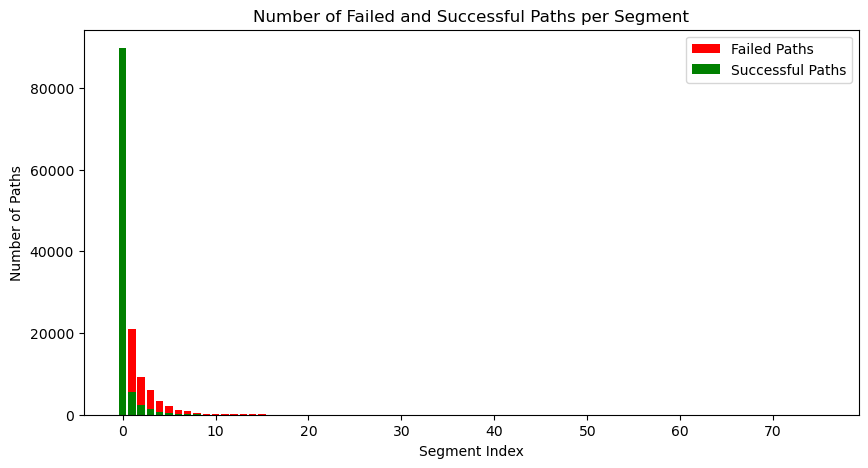

In [29]:
#plotting
all_finalfails = df.path_fail_per_segment.to_list()
all_finalsuccess = df.path_success_per_segment.to_list()

per_segment_fails = {}
for result in all_finalfails:
    for segment_index, count in result.items():
        per_segment_fails[segment_index] = per_segment_fails.get(segment_index, 0) + count


per_segment_success = {}
for result in all_finalsuccess:
    for segment_index, count in result.items():
        per_segment_success[segment_index] = per_segment_success.get(segment_index, 0) + count

per_segment_fails = {k: v for k, v in sorted(per_segment_fails.items(), key=lambda item: item[0])}
per_segment_success = {k: v for k, v in sorted(per_segment_success.items(), key=lambda item: item[0])}

print(per_segment_fails)

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(per_segment_fails.keys(), per_segment_fails.values(), label="Failed Paths", color='red')
ax.bar(per_segment_success.keys(), per_segment_success.values(), label="Successful Paths", color='green')
ax.set_xlabel("Segment Index")
ax.set_ylabel("Number of Paths")
ax.set_title("Number of Failed and Successful Paths per Segment")
ax.legend()


# fig, ax = plt.subplots(figsize=(10, 5))
# ax.bar(df['correct_answer'], df['num_paths'], color=df['correct_answer'].map({True: 'green', False: 'red'}))
# ax.set_xlabel("Correct Answer")
# ax.set_ylabel("Number of Segments")
# ax.set_title("Number of Segments per Correct Answer")

# fig, ax = plt.subplots(figsize=(10, 5))
# ax.bar(df['correct_answer'], df['mean_calls'], color=df['correct_answer'].map({True: 'green', False: 'red'}))
# ax.set_xlabel("Correct Answer")
# ax.set_ylabel("Mean Number of Calls")
# ax.set_title("Mean Number of Calls per Correct Answer")

# fig, ax = plt.subplots(figsize=(10, 5))
# ax.bar(df['correct_answer'], df['mean_fails'], color=df['correct_answer'].map({True: 'green', False: 'red'}))
# ax.set_xlabel("Correct Answer")
# ax.set_ylabel("Mean Number of Fails")
# ax.set_title("Mean Number of Fails per Correct Answer")

# fig, ax = plt.subplots(figsize=(10, 5))
# ax.bar(df['correct_answer'], df['overlap_predicates'], color=df['correct_answer'].map({True: 'green', False: 'red'}))
# ax.set_xlabel("Correct Answer")
# ax.set_ylabel("Number of Overlapping Predicates")
# ax.set_title("Number of Overlapping Predicates per Correct Answer")

# fig, ax = plt.subplots(figsize=(10, 5))
# ax.bar(df['correct_answer'], df['unique_predicates_trace'], color=df['correct_answer'].map({True: 'green', False: 'red'}))
# ax.set_xlabel("Correct Answer")
# ax.set_ylabel("Number of Unique Predicates in Trace")
# ax.set_title("Number of Unique Predicates in Trace per Correct Answer")

# fig, ax = plt.subplots(figsize=(10, 5))
# ax.bar(df['correct_answer'], df['unique_predicates_code'], color=df['correct_answer'].map({True: 'green', False: 'red'}))
# ax.set_xlabel("Correct Answer")
# ax.set_ylabel("Number of Unique Predicates in Code")
# ax.set_title("Number of Unique Predicates in Code per Correct Answer")

# fig, ax = plt.subplots(figsize=(10, 5))
# ax.bar(df['correct_answer'], df['total_assumed_atoms_code'], color=df['correct_answer'].map({True: 'green', False: 'red'}))
# ax.set_xlabel("Correct Answer")
# ax.set_ylabel("Number of Assumed Atoms in Code")
# ax.set_title("Number of Assumed Atoms in Code per Correct Answer")

# fig, ax = plt.subplots(figsize=(10, 5))
# ax.bar(df['correct_answer'], df['overlap_predicates_assumed_atoms'], color=df['correct_answer'].map({True: 'green', False: 'red'}))
# ax.set_xlabel("Correct Answer")
# ax.set_ylabel("Number of Overlapping Predicates and Assumed Atoms")
# ax.set_title("Number of Overlapping Predicates and Assumed Atoms per Correct Answer")




In [8]:
df.columns

Index(['file', 'num_paths', 'calls_per_segment', 'fails_per_segment',
       'path_fail_per_segment', 'path_success_per_segment', 'total_calls',
       'ratio_calls', 'mean_calls', 'max_calls', 'min_calls', 'std_calls',
       'median_calls', 'total_fails', 'ratio_fails', 'mean_fails', 'max_fails',
       'min_fails', 'std_fails', 'median_fails', 'final_answer',
       'initial_answer', 'total_predicate_fact_combinations_trace',
       'total_predicate_fact_combinations_code', 'total_predicates_trace',
       'total_predicates_code', 'total_facts_trace', 'total_facts_code',
       'overlap_predicates', 'overlap_facts', 'overlap_predicates_facts',
       'unique_predicates_trace', 'unique_predicates_code',
       'unique_facts_trace', 'unique_facts_code',
       'unique_predicates_facts_combinations_trace',
       'unique_predicates_facts_combinations_code',
       'attempted_variable_substitutions', 'total_assumed_atoms_code',
       'overlap_predicates_assumed_atoms', 'overlap_facts_a

In [9]:
df.model.value_counts()

model
command-r-plus                      1524
gpt-3.5-turbo                       1524
command-r                           1524
Mixtral-8x7B-v0.1                    762
Meta-Llama-3-8B                      508
Meta-Llama-3.1-8B-Instruct-Turbo     254
Name: count, dtype: int64

<Axes: xlabel='model,icl'>

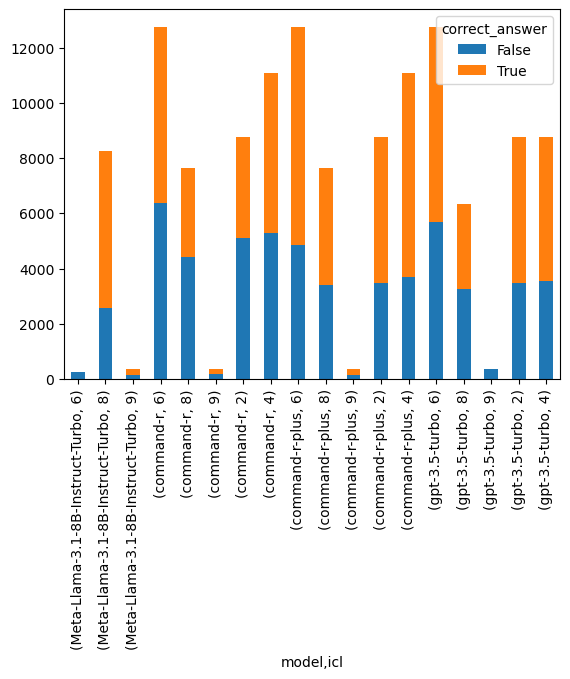

In [30]:
df.groupby(['model','icl'])['correct_answer'].value_counts().unstack().plot(kind='bar', stacked=True)

/home/kirekara/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/kirekara/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/kirekara/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/kirekara/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/kirekara/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/home/kirekara/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has change

Grouping by:  [('correct_answer',), ('model',), ('icl',), ('correct_answer', 'model'), ('correct_answer', 'icl'), ('model', 'icl'), ('correct_answer', 'model', 'icl')]
| correct_answer   |   num_paths |   mean_calls |   mean_fails |   total_calls |   total_fails |
|:-----------------|------------:|-------------:|-------------:|--------------:|--------------:|
| False            |     1.10704 |      6.67534 |     0.856974 |       8.72798 |      1.22786  |
| True             |     1.02668 |      6.87756 |     0.390969 |       8.66042 |      0.551187 |



| model                            |   num_paths |   mean_calls |   mean_fails |   total_calls |   total_fails |
|:---------------------------------|------------:|-------------:|-------------:|--------------:|--------------:|
| Meta-Llama-3.1-8B-Instruct-Turbo |    1.42199  |      9.49659 |     0.931683 |      12.6104  |      1.35635  |
| command-r                        |    1.33461  |      6.75622 |     0.581413 |      10.5767  |      

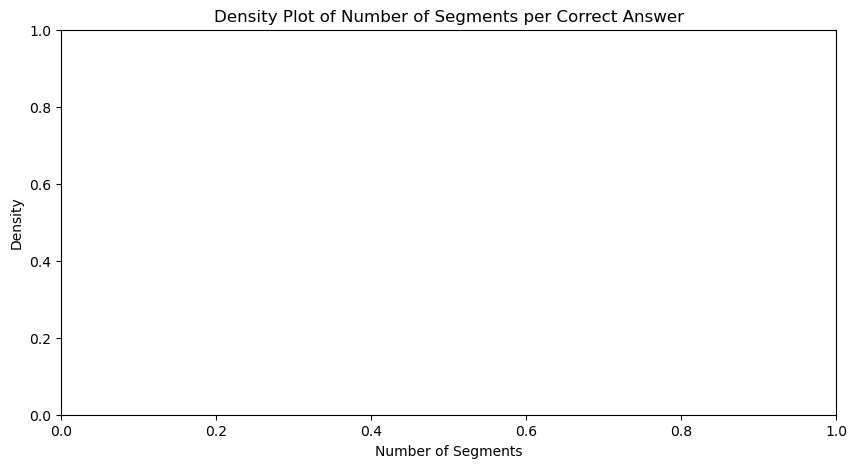

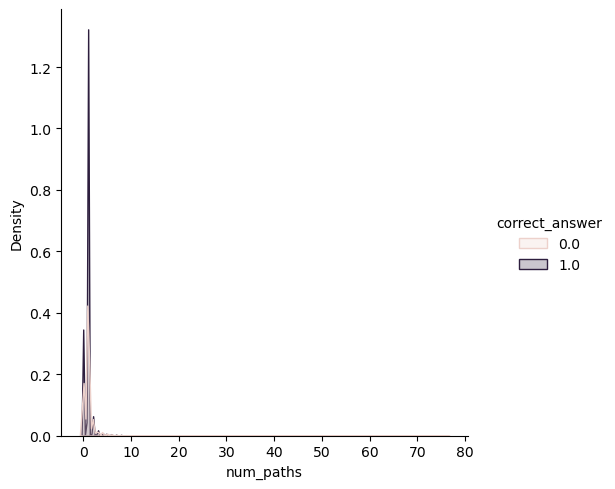

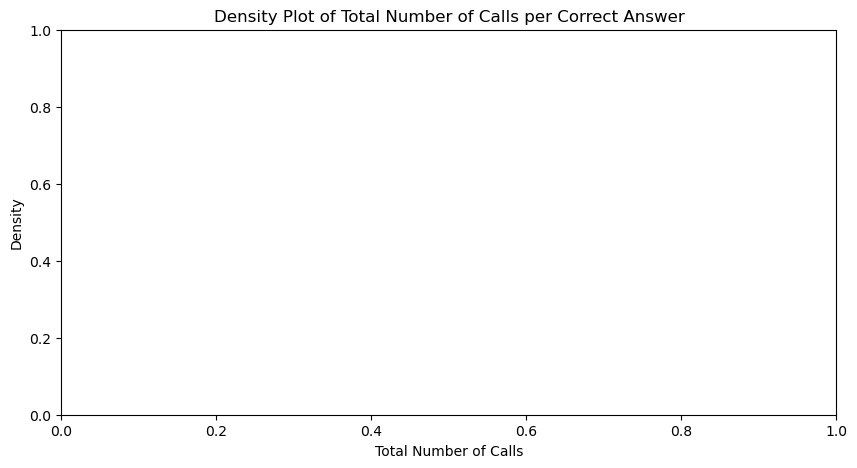

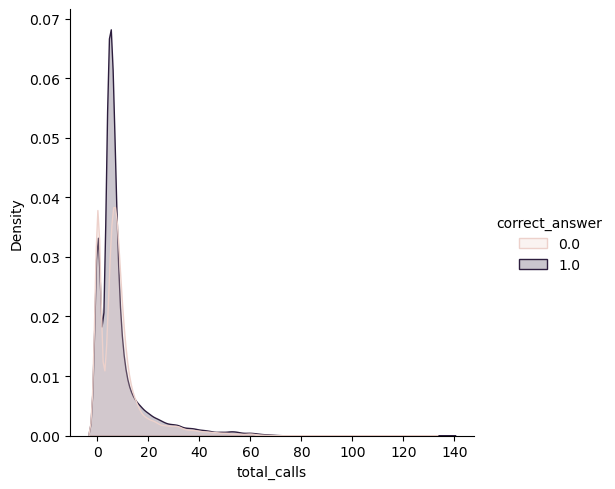

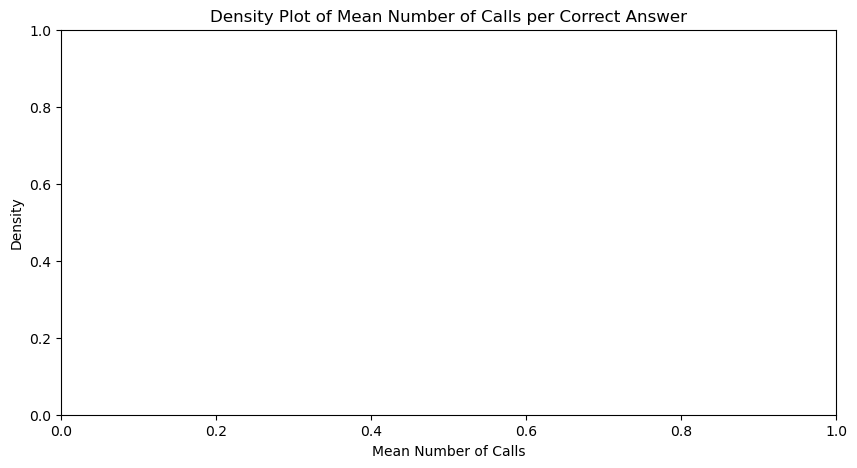

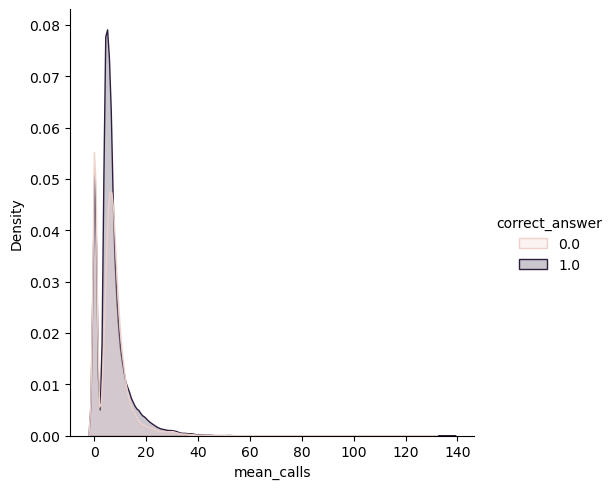

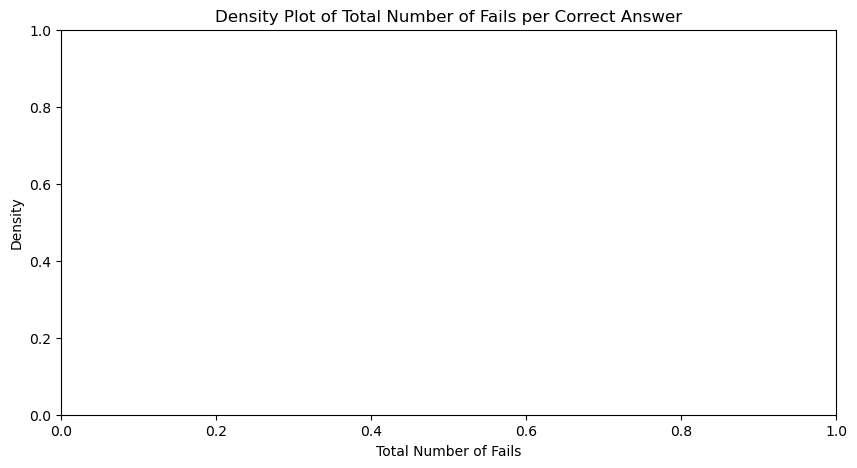

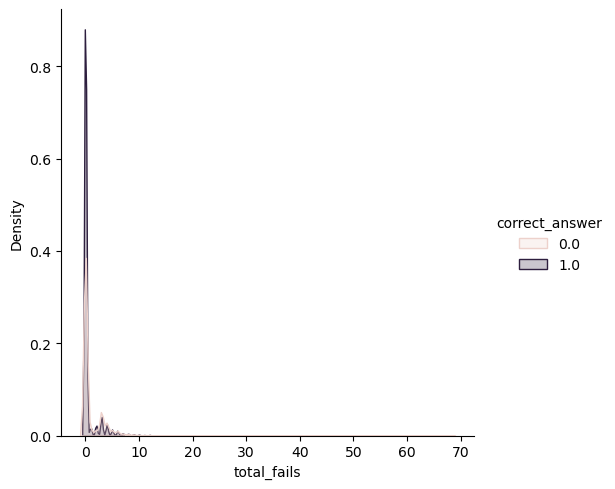

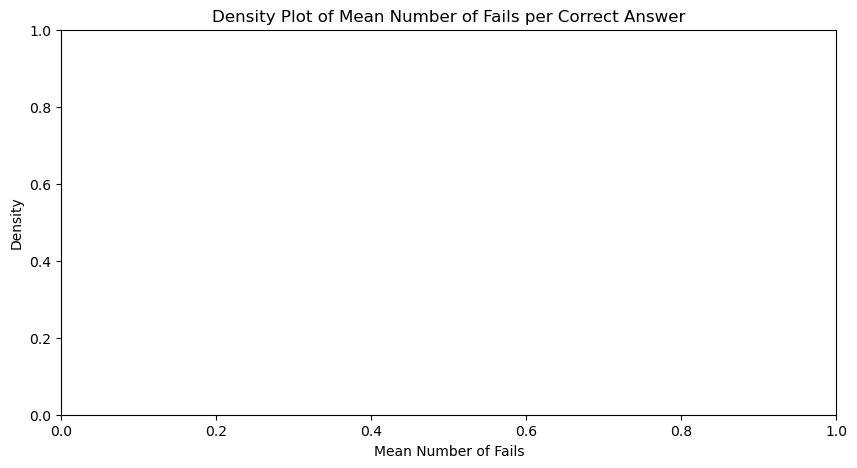

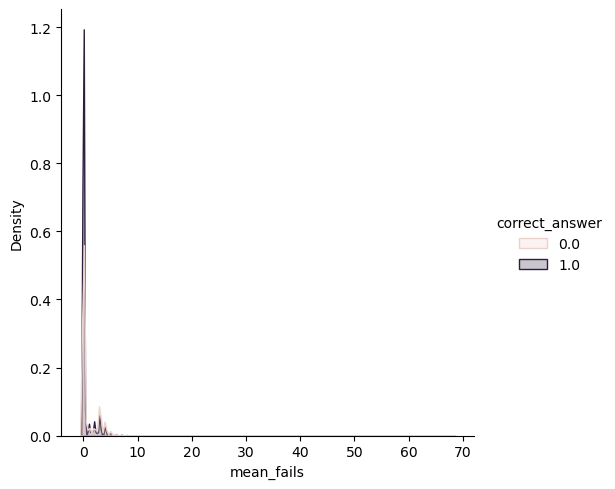

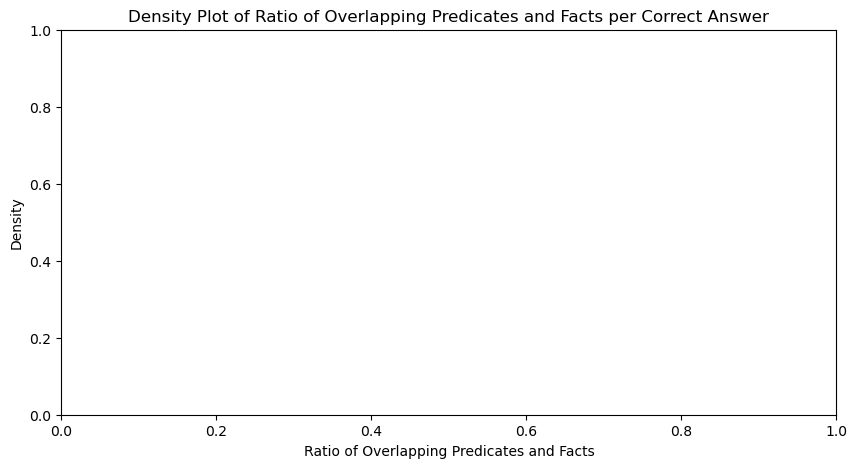

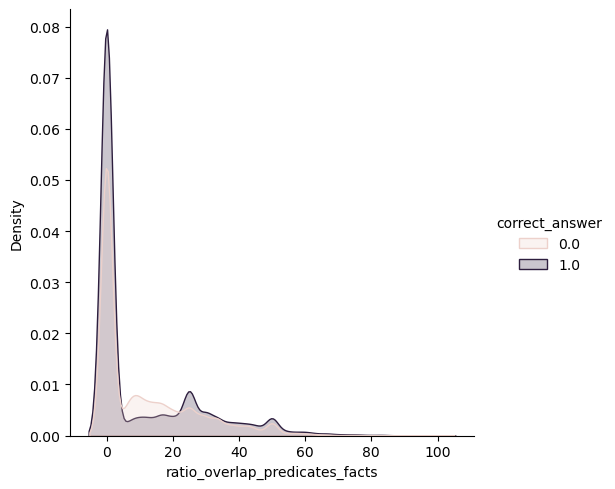

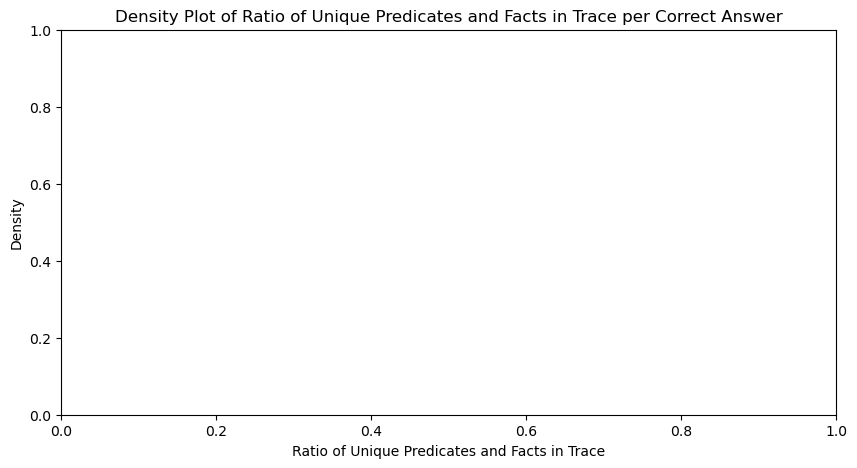

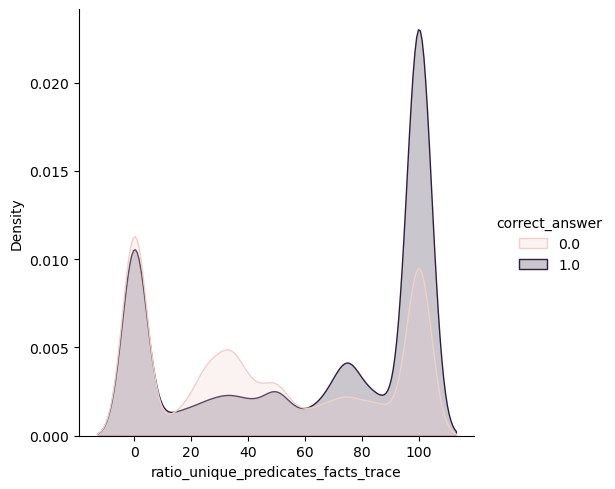

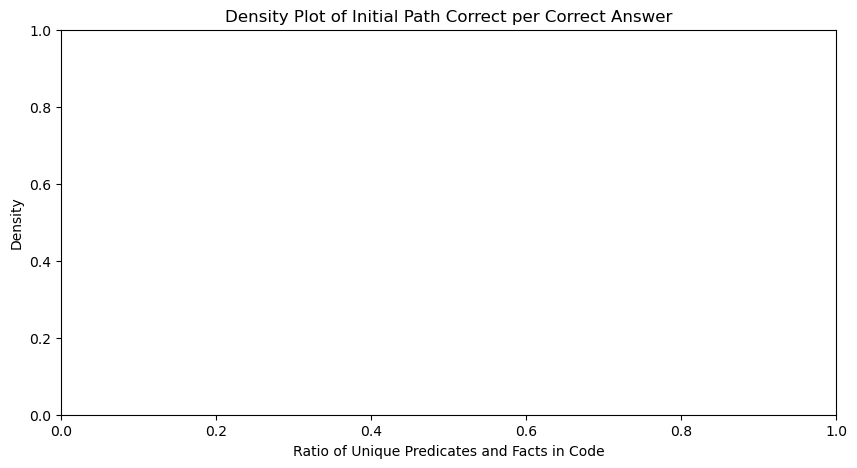

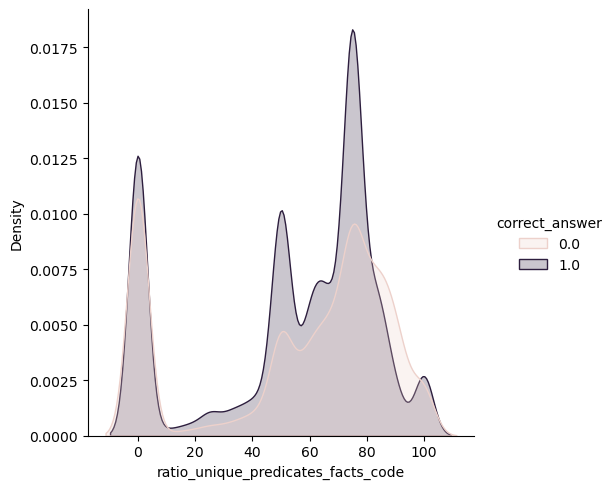

In [33]:
from itertools import combinations

# df = df[df['num_paths'] > 0]
# df = df[df['mean_calls'] > 0]
# df = df[df['mean_fails'] > 0]

fig, ax = plt.subplots(figsize=(10, 5))
sns.displot(df, x="num_paths", hue="correct_answer", kind="kde", fill=True)
ax.set_xlabel("Number of Segments")
ax.set_ylabel("Density")
ax.set_title("Density Plot of Number of Segments per Correct Answer")

fig, ax = plt.subplots(figsize=(10, 5))
sns.displot(df, x="total_calls", hue="correct_answer", kind="kde", fill=True)
ax.set_xlabel("Total Number of Calls")
ax.set_ylabel("Density")
ax.set_title("Density Plot of Total Number of Calls per Correct Answer")

fig, ax = plt.subplots(figsize=(10, 5))
sns.displot(df, x="mean_calls", hue="correct_answer", kind="kde", fill=True)
ax.set_xlabel("Mean Number of Calls")
ax.set_ylabel("Density")
ax.set_title("Density Plot of Mean Number of Calls per Correct Answer")

fig, ax = plt.subplots(figsize=(10, 5))
sns.displot(df, x="total_fails", hue="correct_answer", kind="kde", fill=True)
ax.set_xlabel("Total Number of Fails")
ax.set_ylabel("Density")
ax.set_title("Density Plot of Total Number of Fails per Correct Answer")

fig, ax = plt.subplots(figsize=(10, 5))
sns.displot(df, x="mean_fails", hue="correct_answer", kind="kde", fill=True)
ax.set_xlabel("Mean Number of Fails")
ax.set_ylabel("Density")
ax.set_title("Density Plot of Mean Number of Fails per Correct Answer")

fig, ax = plt.subplots(figsize=(10, 5))
sns.displot(df, x="ratio_overlap_predicates_facts", hue="correct_answer", kind="kde", fill=True)
ax.set_xlabel("Ratio of Overlapping Predicates and Facts")
ax.set_ylabel("Density")
ax.set_title("Density Plot of Ratio of Overlapping Predicates and Facts per Correct Answer")

fig, ax = plt.subplots(figsize=(10, 5))
sns.displot(df, x="ratio_unique_predicates_facts_trace", hue="correct_answer", kind="kde", fill=True)
ax.set_xlabel("Ratio of Unique Predicates and Facts in Trace")
ax.set_ylabel("Density")
ax.set_title("Density Plot of Ratio of Unique Predicates and Facts in Trace per Correct Answer")

fig, ax = plt.subplots(figsize=(10, 5))
sns.displot(df, x="ratio_unique_predicates_facts_code", hue="correct_answer", kind="kde", fill=True)
ax.set_xlabel("Ratio of Unique Predicates and Facts in Code")
ax.set_ylabel("Density")
ax.set_title("Density Plot of Ratio of Unique Predicates and Facts in Code per Correct Answer")

# fig, ax = plt.subplots(figsize=(10, 5))
# sns.displot(df, x="final_path_correct", hue="correct_answer", kind="kde", fill=True)
# ax.set_xlabel("Final Path Correct")
# ax.set_ylabel("Density")
# ax.set_title("Density Plot of Final Path Correct per Correct Answer")

# fig, ax = plt.subplots(figsize=(10, 5))
# sns.displot(df, x="initial_path_correct", hue="correct_answer", kind="kde", fill=True)
# ax.set_xlabel("Initial Path Correct")
# ax.set_ylabel("Density")
ax.set_title("Density Plot of Initial Path Correct per Correct Answer")

# fig, ax = plt.subplots(figsize=(10, 5))
# sns.displot(df, x="final_path_matches_final_prediction", hue="correct_answer", kind="kde", fill=True)
# ax.set_xlabel("Final Path Matches Final Prediction")
# ax.set_ylabel("Density")
# ax.set_title("Density Plot of Final Path Matches Final Prediction per Correct Answer")



def create_tables(df, groupby_columns, columns):
    combinations_to_group = []
    for i in range(1, len(groupby_columns)+1):
        combinations_to_group.extend(combinations(groupby_columns, i)) 
    
    print("Grouping by: ", combinations_to_group)
    for combination in combinations_to_group:
        tab = df.groupby(list(combination))[columns].mean()
        if len(combination) ==1:
            tab = tab.sort_index(level=0)
        else:
            tab = tab.sort_index(level=1)

        print(tab.to_markdown())
        print("\n\n")

create_tables(df, ['correct_answer', 'model', 'icl'], ["num_paths", "mean_calls", "mean_fails", "total_calls", "total_fails"])
create_tables(df, ['correct_answer', 'model', 'icl'], ["ratio_calls", "ratio_fails"])
create_tables(df, ['correct_answer', 'model', 'icl'], ["total_predicate_fact_combinations_trace", "total_predicate_fact_combinations_code", "overlap_predicates", "overlap_facts"])
create_tables(df, ['correct_answer', 'model', 'icl'], ["unique_predicates_trace", "unique_predicates_code", "unique_predicates_facts_combinations_trace", "unique_predicates_facts_combinations_code"])
create_tables(df, ['correct_answer', 'model', 'icl'], ["attempted_variable_substitutions", "total_assumed_atoms_code", "overlap_predicates_assumed_atoms"])
create_tables(df, ['correct_answer', 'model', 'icl'], ["ratio_overlap_predicates", "ratio_overlap_facts", "ratio_overlap_predicates_facts"])
create_tables(df, ['correct_answer', 'model', 'icl'], ["ratio_unique_predicates_facts_trace", "ratio_unique_predicates_facts_code", "ratio_unique_predicates_trace", "ratio_unique_predicates_code", "ratio_unique_facts_trace", "ratio_unique_facts_code"])   
create_tables(df, ['correct_answer', 'model', 'icl'], ["ratio_overlap_predicates_assumed_atoms", "ratio_overlap_facts_assumed_atoms", "ratio_overlap_predicates_facts_assumed_atoms"])
create_tables(df, ['correct_answer', 'model', 'icl'], ["final_path_correct", "initial_path_correct"])
create_tables(df, ['correct_answer', 'model'], ["final_path_matches_final_prediction", "initial_path_matches_final_prediction"])

#table
# tab =df.groupby(['correct_answer'])[["num_paths", "mean_calls", "mean_fails", "total_calls", "total_fails"]].mean()
# #sort by model
# tab = tab.sort_index(level=0)
# # tab = tab.sort_index(level=2)
# #print markdown
# print(tab.to_markdown())
# print("\n\n")

# #table
# tab =df.groupby(['correct_answer', 'model'])[["num_paths", "mean_calls", "mean_fails", "total_calls", "total_fails"]].mean()
# #sort by model
# tab = tab.sort_index(level=1)
# # tab = tab.sort_index(level=2)
# #print markdown
# print(tab.to_markdown())
# print("\n\n")


# #table
# tab =df.groupby(['correct_answer', 'model', 'icl'])[["num_paths", "mean_calls", "mean_fails", "total_calls", "total_fails"]].mean()
# #sort by model, correct answer and icl
# tab = tab.sort_index(level=1)
# tab = tab.sort_index(level=0)
# tab = tab.sort_index(level=2)
# #print markdown
# print(tab.to_markdown())
# print("\n\n")

#absolute difference between correct and incorrect answers averaged over models and icl
# tab =df.groupby(['correct_answer'])[["num_paths", "mean_calls", "mean_fails", "total_calls", "total_fails"]].mean()
# tab = tab.diff()
# #sort by model
# tab = tab.sort_index(level=1)

# #print markdown
# print(tab.to_markdown())


# tab =df.groupby(['correct_answer', 'model', 'icl'])[["total_predicate_fact_combinations_trace", "total_predicate_fact_combinations_code", "total_predicates_trace", "total_predicates_code", "total_facts_trace", "total_facts_code", "overlap_predicates", "unique_predicates_trace", "unique_predicates_code", "unique_predicates_facts_combinations_trace", "unique_predicates_facts_combinations_code", "attempted_variable_substitutions", "total_assumed_atoms_code", "overlap_predicates_assumed_atoms"]].mean()
# tab = tab.sort_index(level=1)
# #print markdown
# print(tab.to_markdown())

# tab =df.groupby(['correct_answer', 'model'])[["num_paths", "mean_calls", "mean_fails", "total_calls", "total_fails"]].max()
# #print markdown
# print(tab.to_markdown())
# print("\n\n")
# tab =df.groupby(['correct_answer', 'model'])[["num_paths", "mean_calls", "mean_fails", "total_calls", "total_fails"]].min()
# #print markdown
# print(tab.to_markdown())


In [ ]:
df.model.value_counts()

## Plotting the path statistics

In [43]:
#change icl to int

df['icl'] = df['icl'].astype(int)

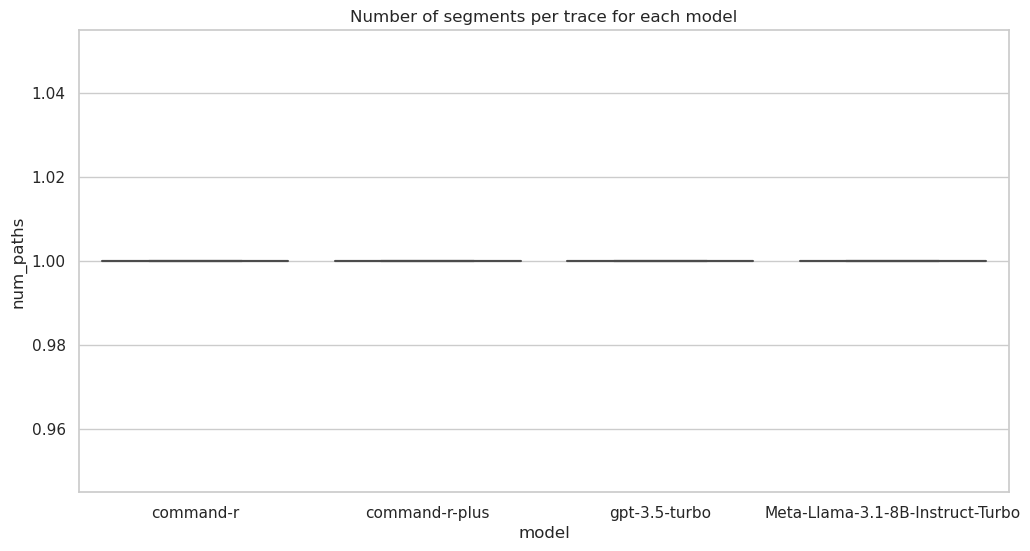

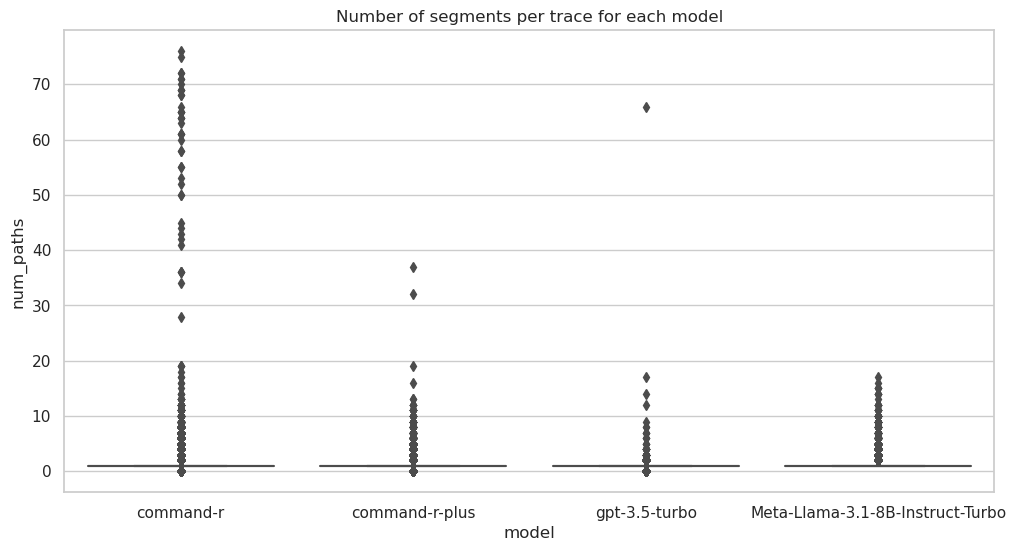

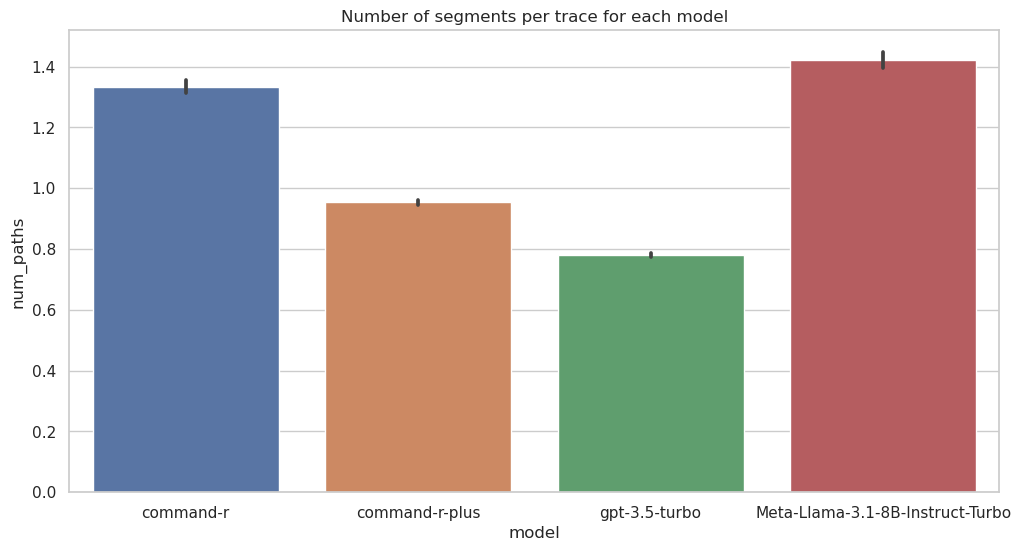

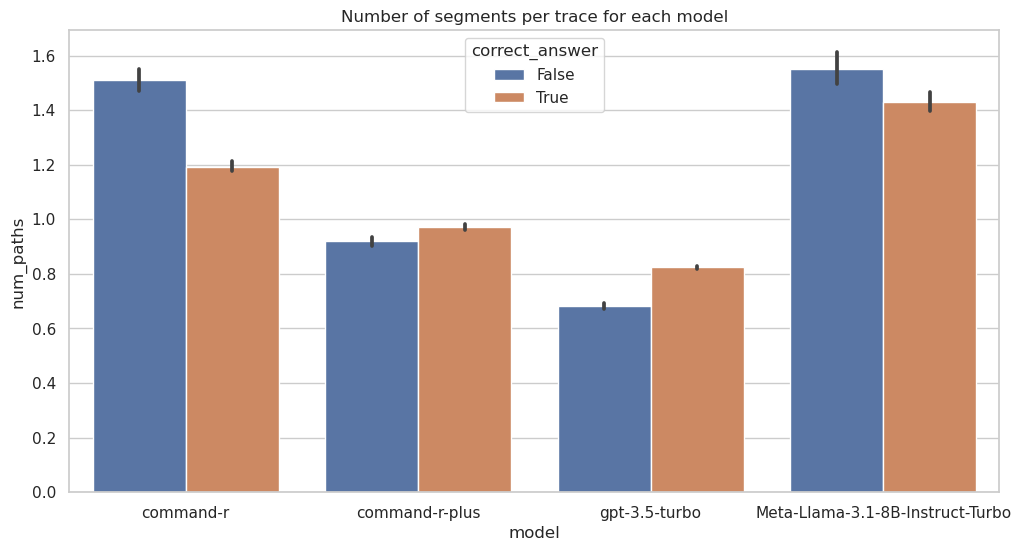

In [60]:
# displot plot of number of segments per trace for each file

def plot_x_y_per_trace_box(df:pd.DataFrame, outliers:bool=False, y:str='num_paths', x:str='model', title:str="Number of segments per trace for each model", meta_filter:str=None):
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    if meta_filter is None:
        sns.boxplot(df, x=x, y=y, ax=ax, showfliers=outliers)
    else:
        sns.boxplot(df, x=x, y=y, ax=ax, showfliers=outliers, hue=meta_filter)
    ax.set_title(title)
    plt.show()

def plot_x_y_per_trace_bar(df:pd.DataFrame, y:str='num_paths', x:str='model', title:str="Number of segments per trace for each model", meta_filter:str=None):
    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))
    if meta_filter is None:
        sns.barplot(df, x=x, y=y, ax=ax)
    else:
        sns.barplot(df, x=x, y=y, ax=ax, hue=meta_filter)
    ax.set_title(title)
    plt.show()



title = "Number of segments per trace for each model"
plot_x_y_per_trace_box(df, outliers=False, title=title)
plot_x_y_per_trace_box(df, outliers=True, title=title)
plot_x_y_per_trace_bar(df, title=title)
plot_x_y_per_trace_bar(df, title=title, meta_filter="correct_answer")

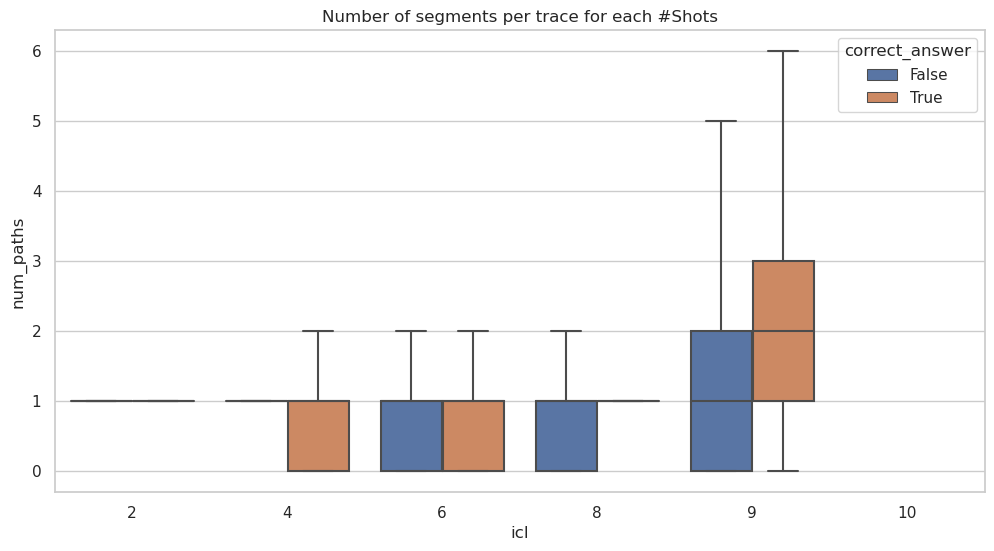

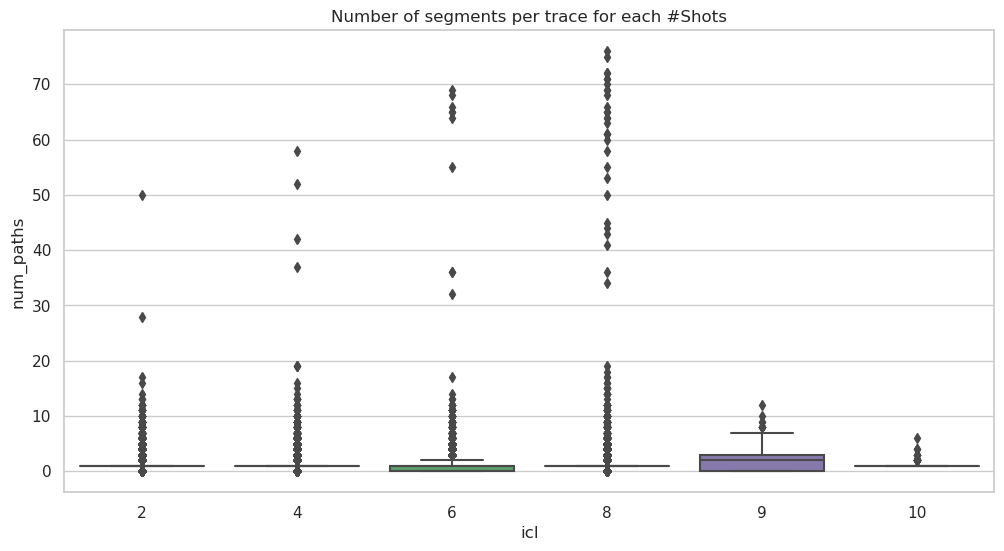

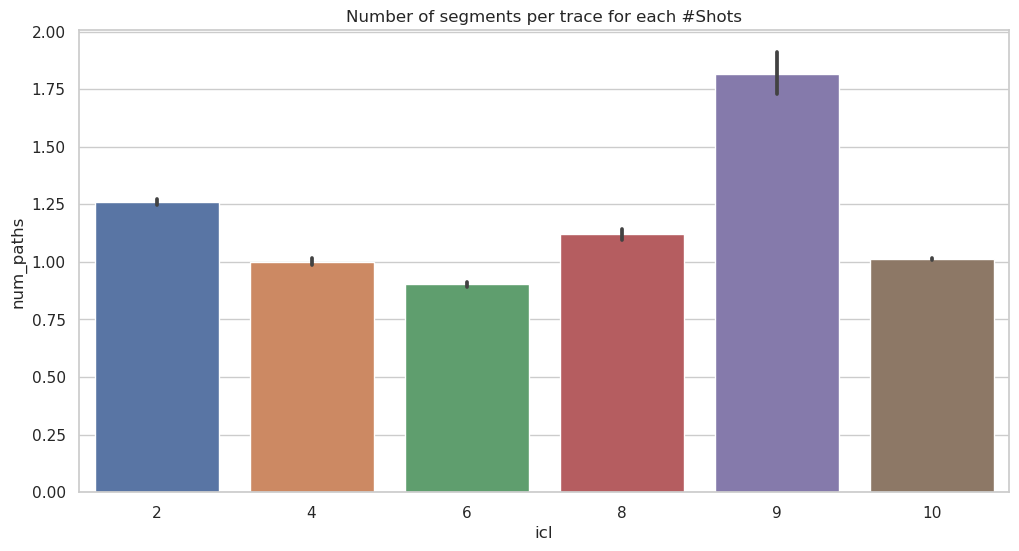

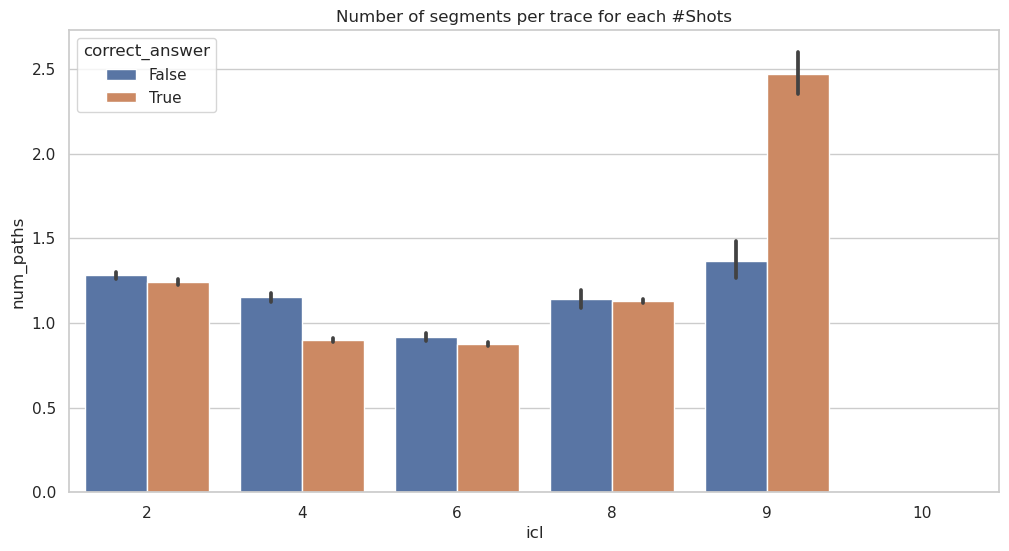

In [65]:
title = "Number of segments per trace for each #Shots"
df = df.sort_values(by='icl')
plot_x_y_per_trace_box(df, outliers=False, x='icl', y='num_paths', title=title, meta_filter="correct_answer")
plot_x_y_per_trace_box(df, outliers=True, x='icl', y='num_paths', title=title)
plot_x_y_per_trace_bar(df, x='icl', y='num_paths', title=title)
plot_x_y_per_trace_bar(df, x='icl', y='num_paths', title=title, meta_filter="correct_answer")

### Hops per path

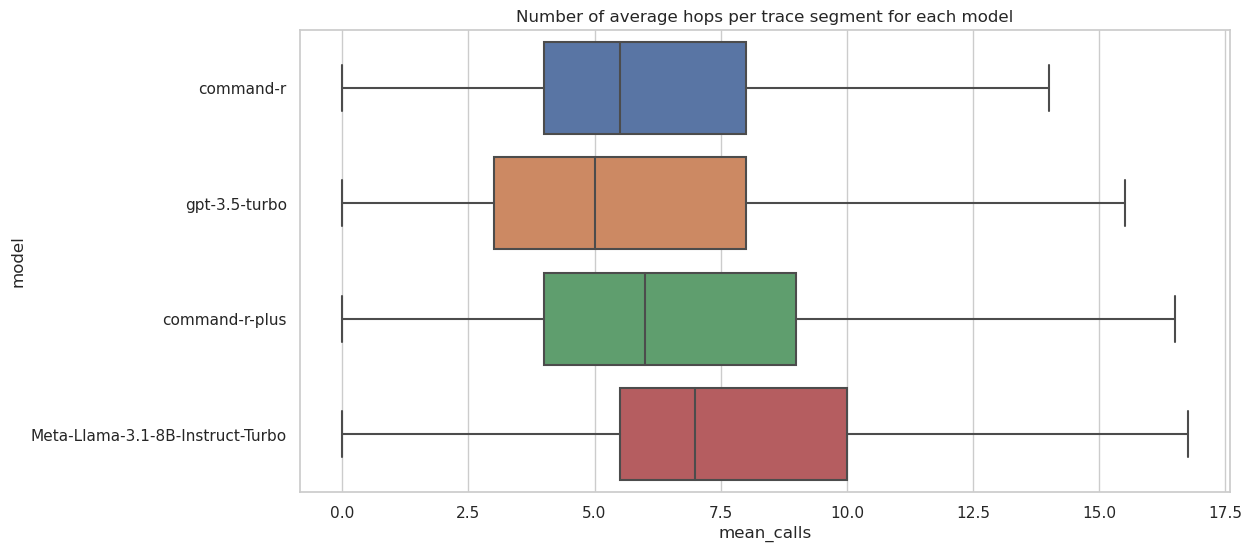

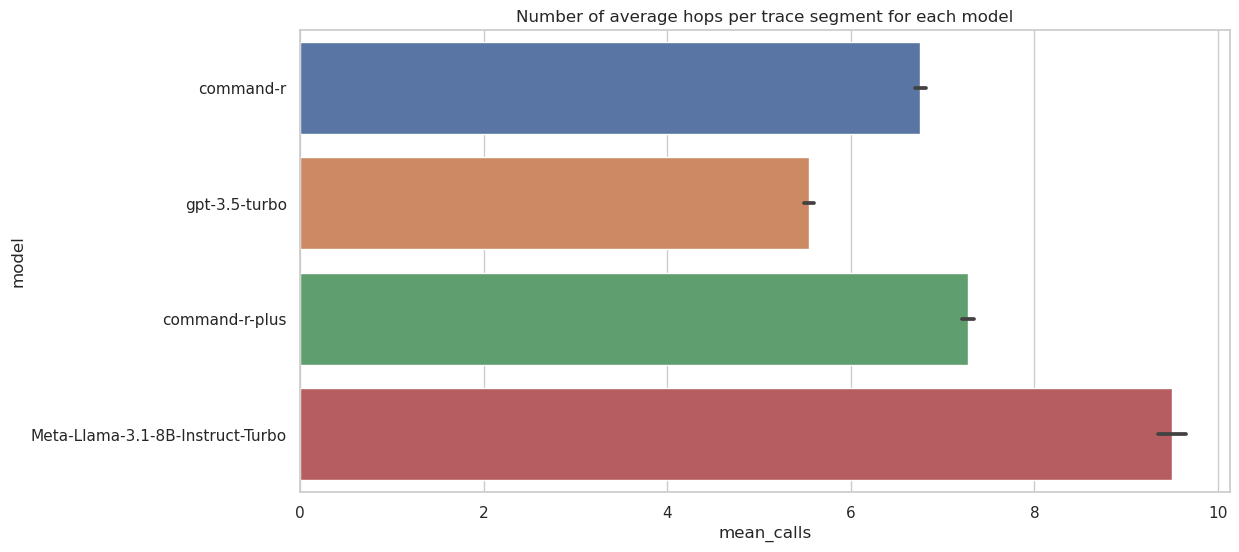

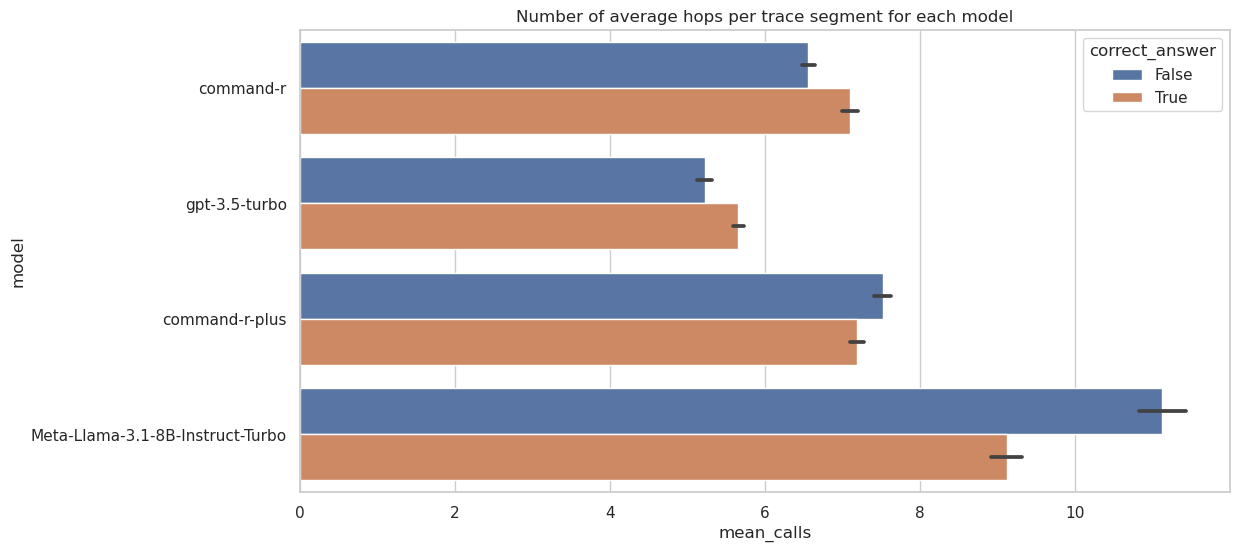

In [62]:
title = "Number of average hops per trace segment for each model"
plot_x_y_per_trace_box(df, outliers=False, x='mean_calls', y='model', title=title)
# plot_x_y_per_trace_box(df, outliers=True, x='mean_calls')
plot_x_y_per_trace_bar(df, x='mean_calls', y='model', title=title)
plot_x_y_per_trace_bar(df, x='mean_calls', y='model', title=title, meta_filter="correct_answer")

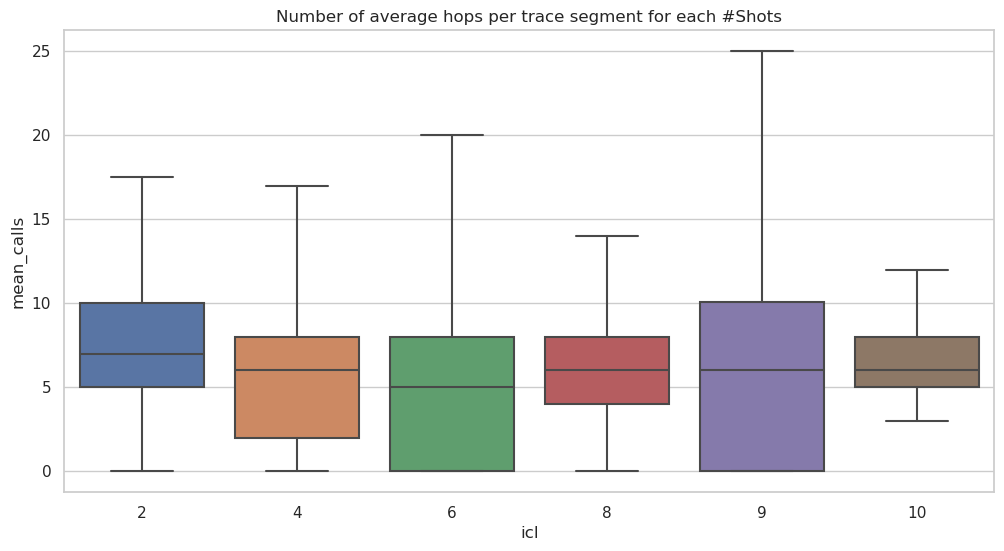

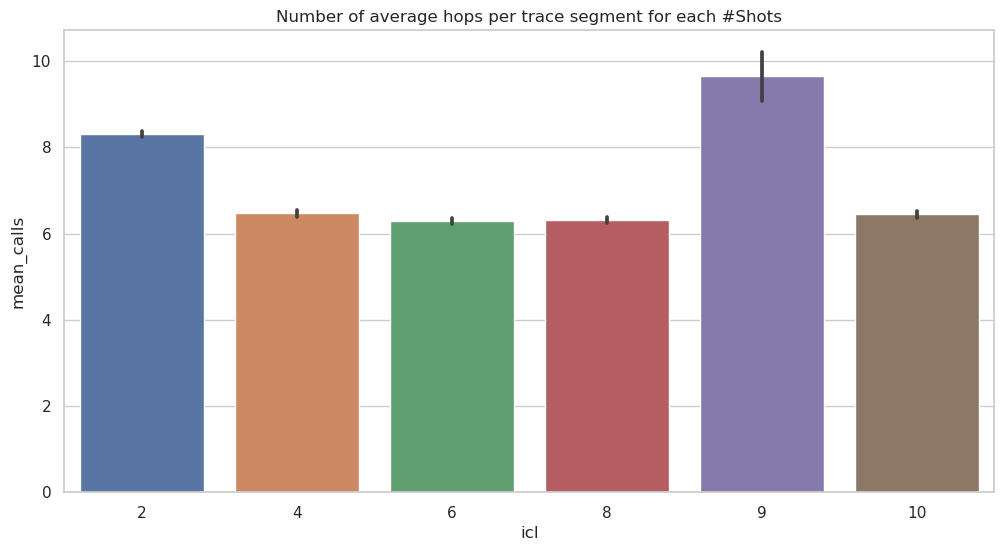

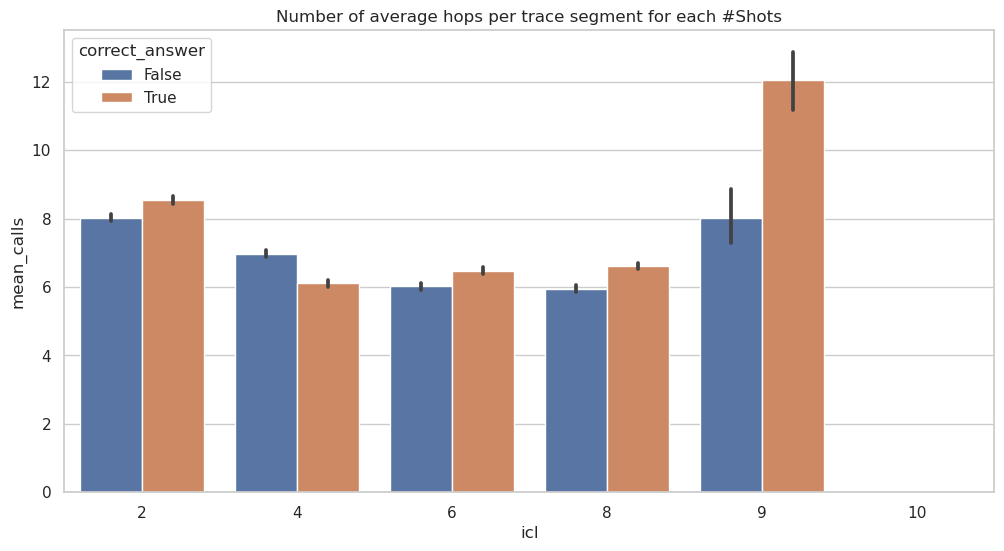

In [64]:
#sort by icl
df = df.sort_values(by='icl')
title = "Number of average hops per trace segment for each #Shots"
sns.set_theme(style="whitegrid")
plot_x_y_per_trace_box(df, outliers=False, x='icl', y='mean_calls', title=title)
# plot_x_y_per_trace_box(df, outliers=True, x='mean_calls')
plot_x_y_per_trace_bar(df, x='icl', y='mean_calls', title=title)
plot_x_y_per_trace_bar(df, x='icl', y='mean_calls', meta_filter="correct_answer", title=title)

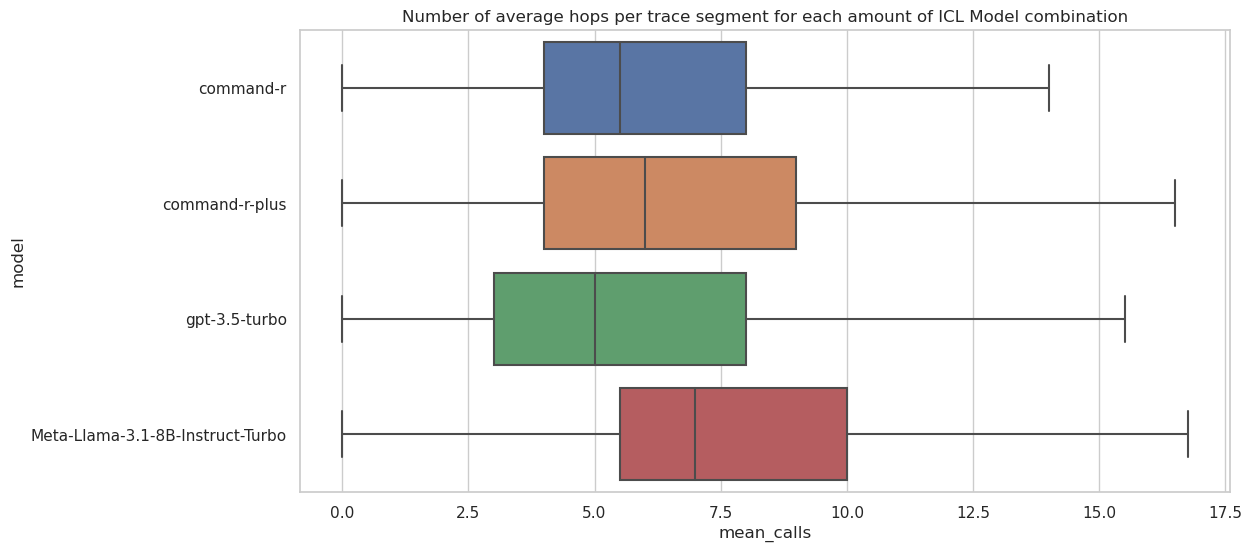

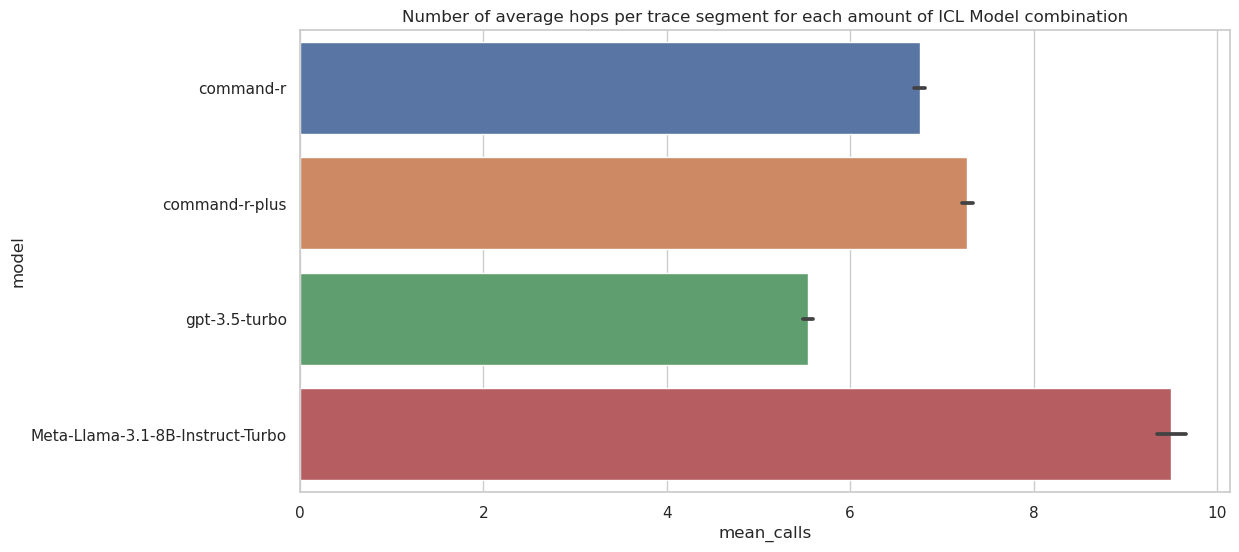

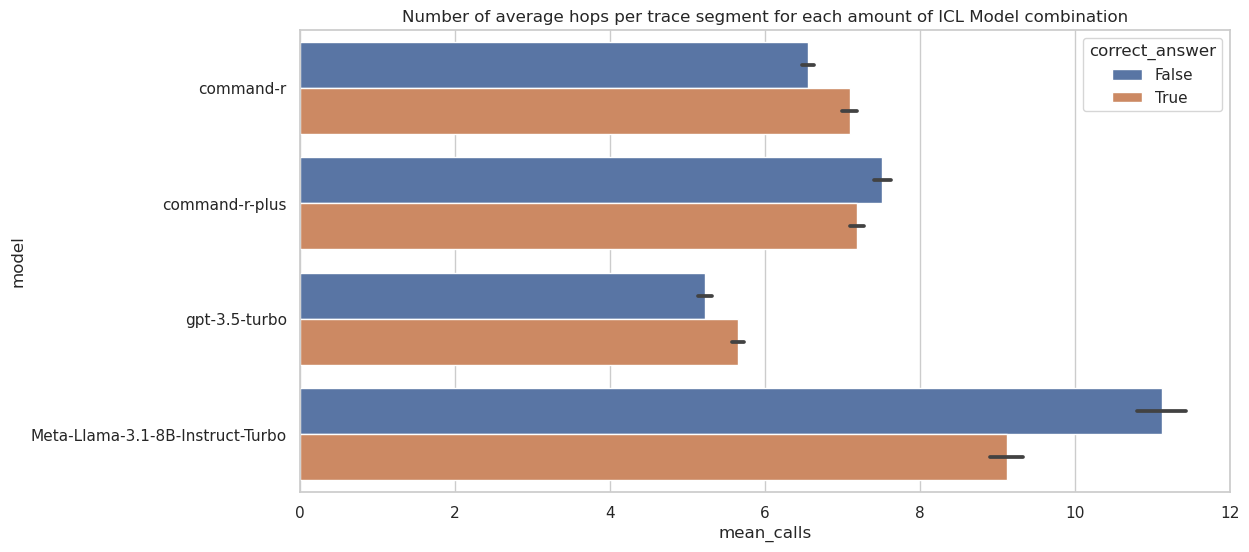

In [67]:
title = "Number of average hops per trace segment for each amount of ICL Model combination"
plot_x_y_per_trace_box(df, outliers=False, x='mean_calls', y='model', title=title)
# plot_x_y_per_trace_box(df, outliers=True, x='max_calls')
plot_x_y_per_trace_bar(df, x='mean_calls', y='model', title=title)
plot_x_y_per_trace_bar(df, x='mean_calls', y='model', meta_filter="correct_answer", title=title)

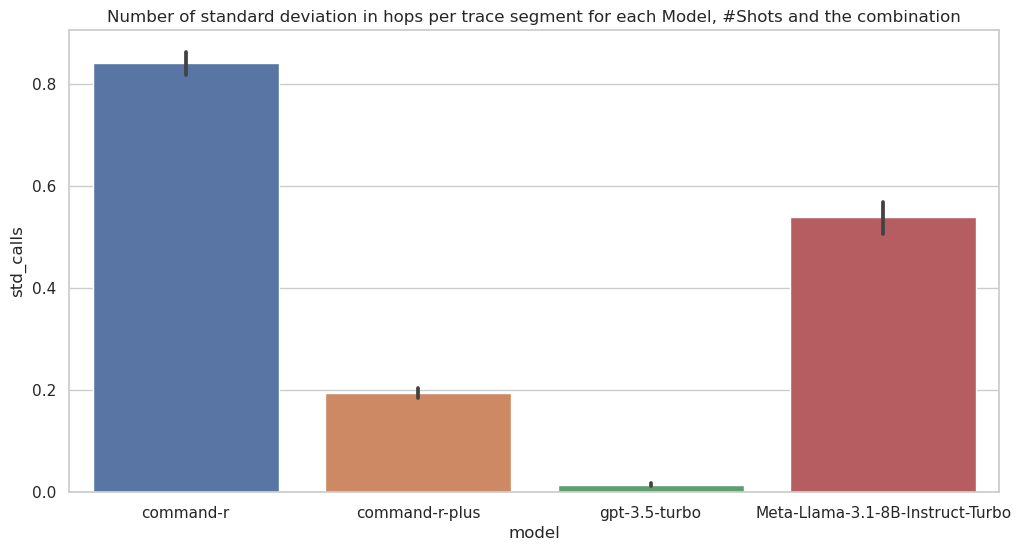

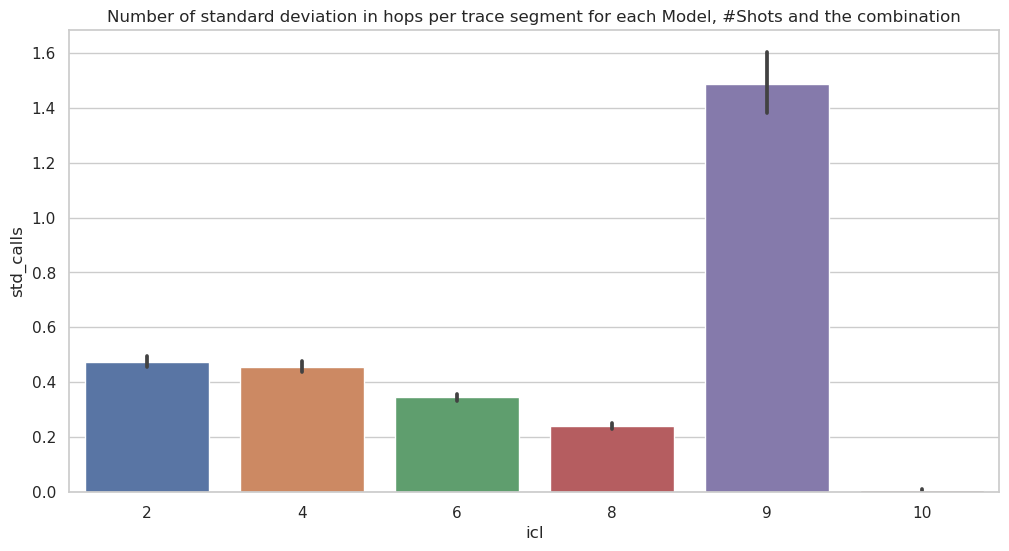

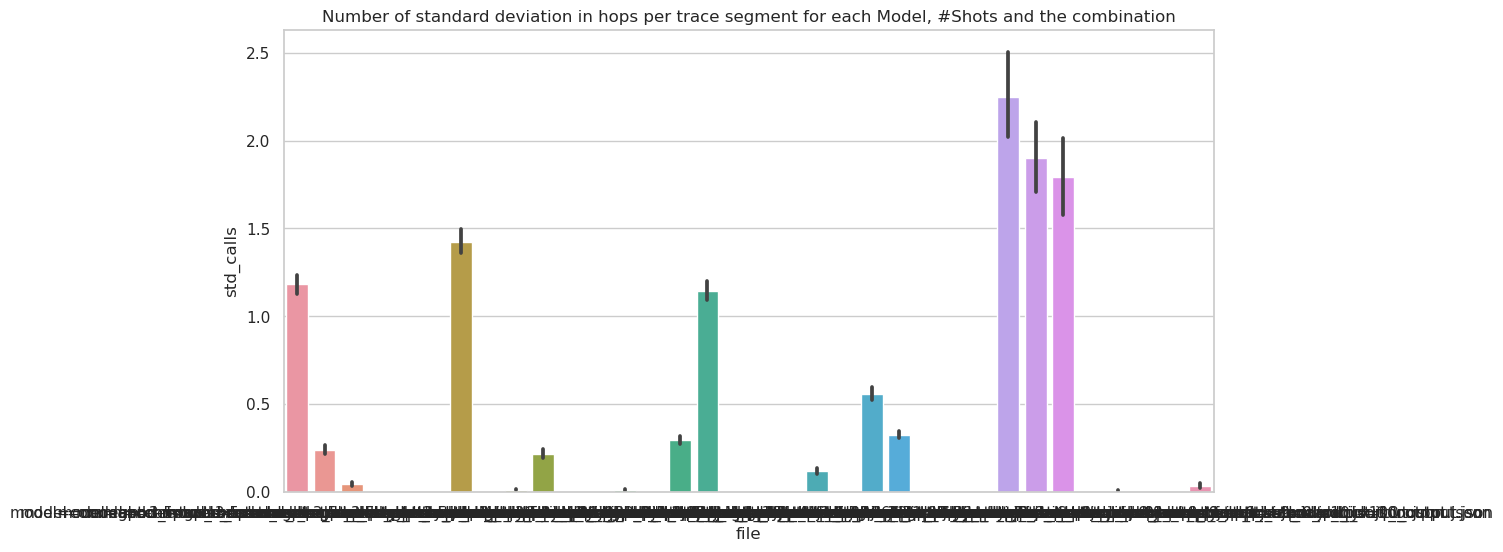

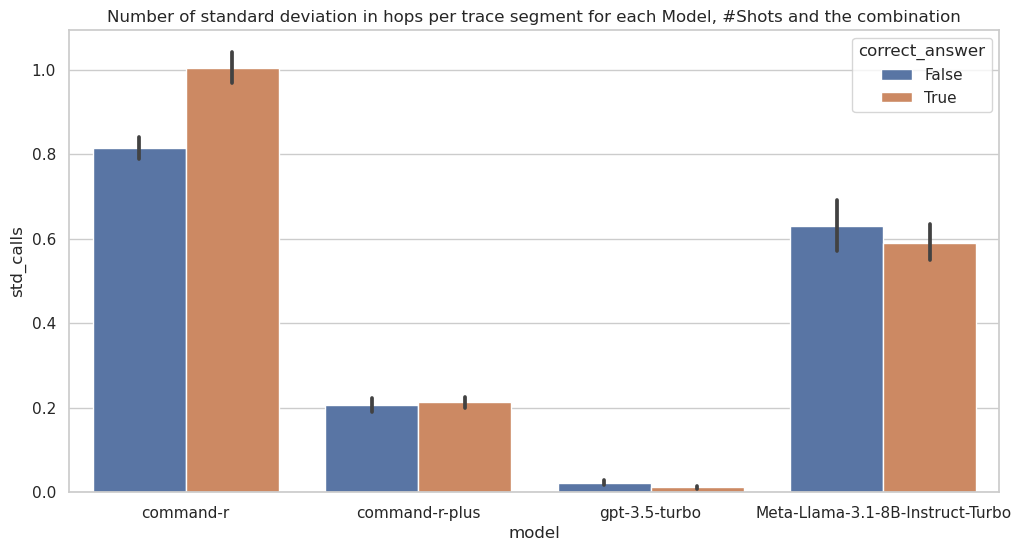

In [70]:
# plot_x_y_per_trace_box(df, outliers=False, x='std_calls', y='file')
# plot_x_y_per_trace_box(df, outliers=True, x='max_calls')
title = "Number of standard deviation in hops per trace segment for each Model, #Shots and the combination"
plot_x_y_per_trace_bar(df, y='std_calls', x='model', title=title)
plot_x_y_per_trace_bar(df, y='std_calls', x='icl', title=title)
plot_x_y_per_trace_bar(df, y='std_calls', x='file', title=title)
plot_x_y_per_trace_bar(df, y='std_calls', x='model', title=title, meta_filter="correct_answer")


### Fails per path

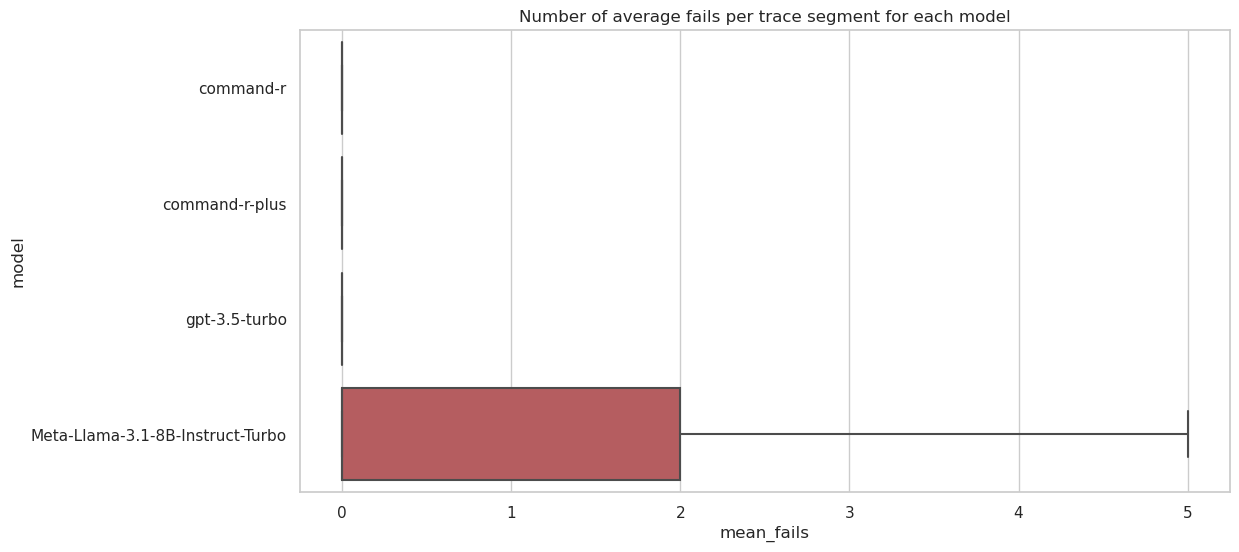

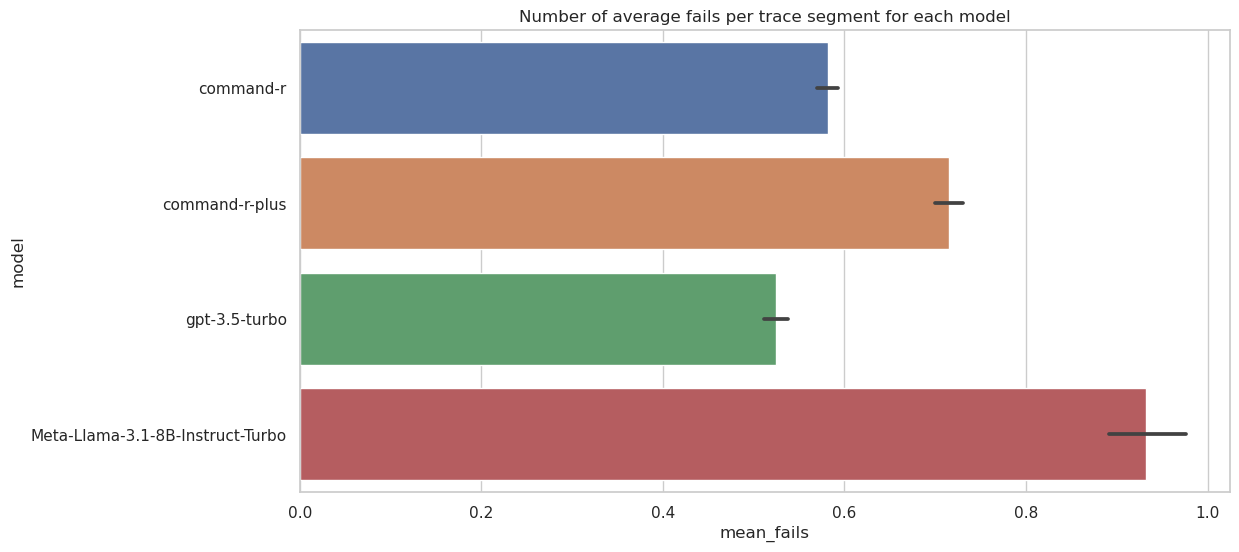

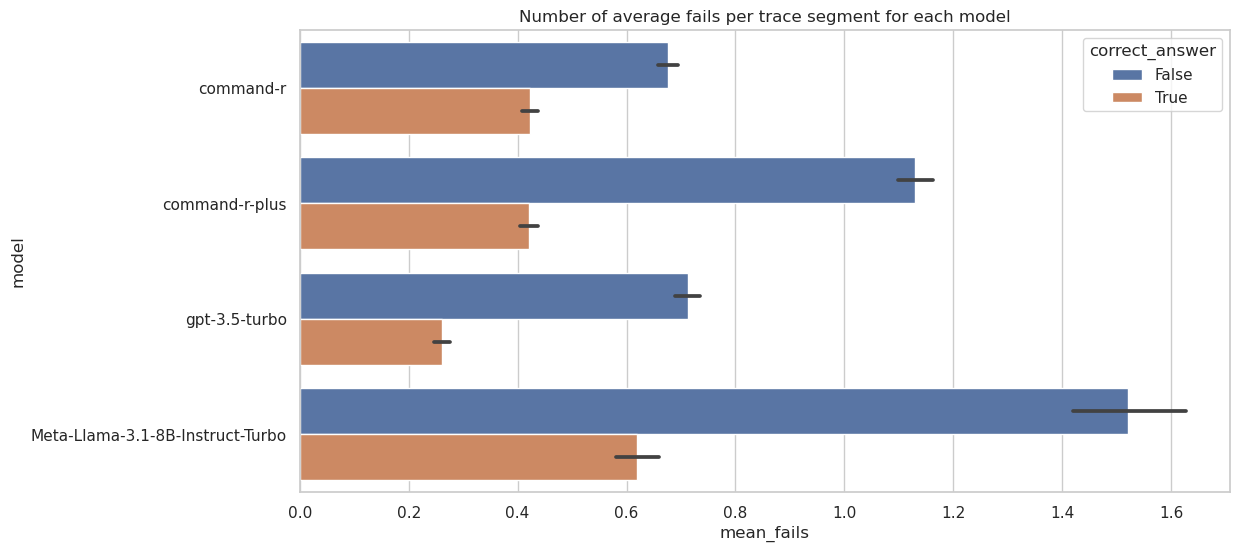

In [71]:
title = "Number of average fails per trace segment for each model"
plot_x_y_per_trace_box(df, outliers=False, x='mean_fails', y='model', title=title)
# plot_x_y_per_trace_box(df, outliers=True, x='mean_fails')
plot_x_y_per_trace_bar(df, x='mean_fails', y='model', title=title)
plot_x_y_per_trace_bar(df, x='mean_fails', y='model', title=title, meta_filter="correct_answer")

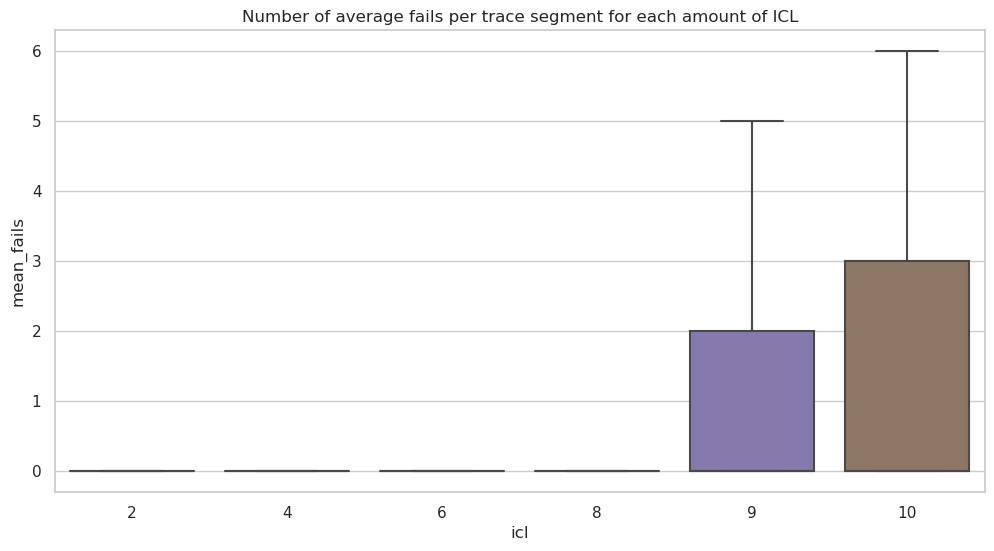

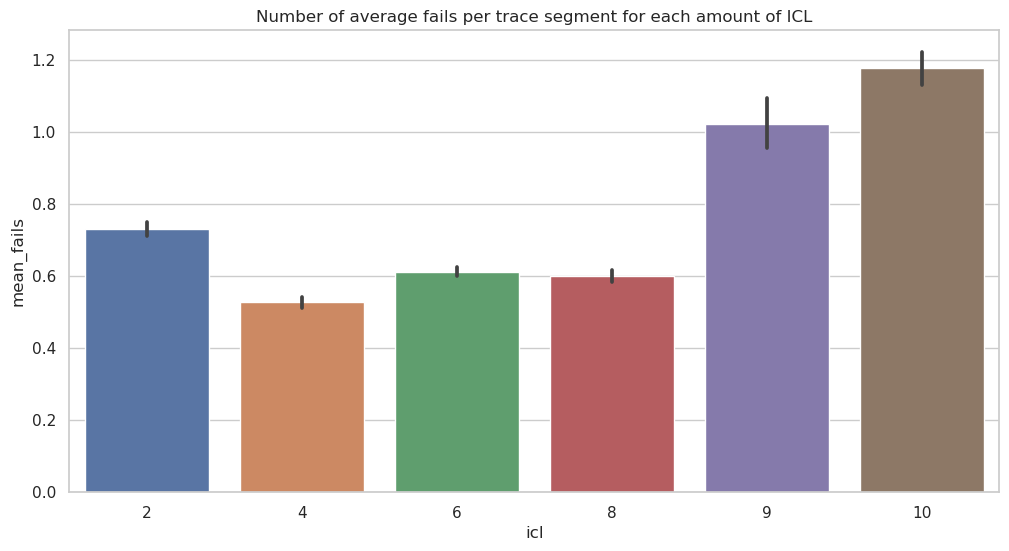

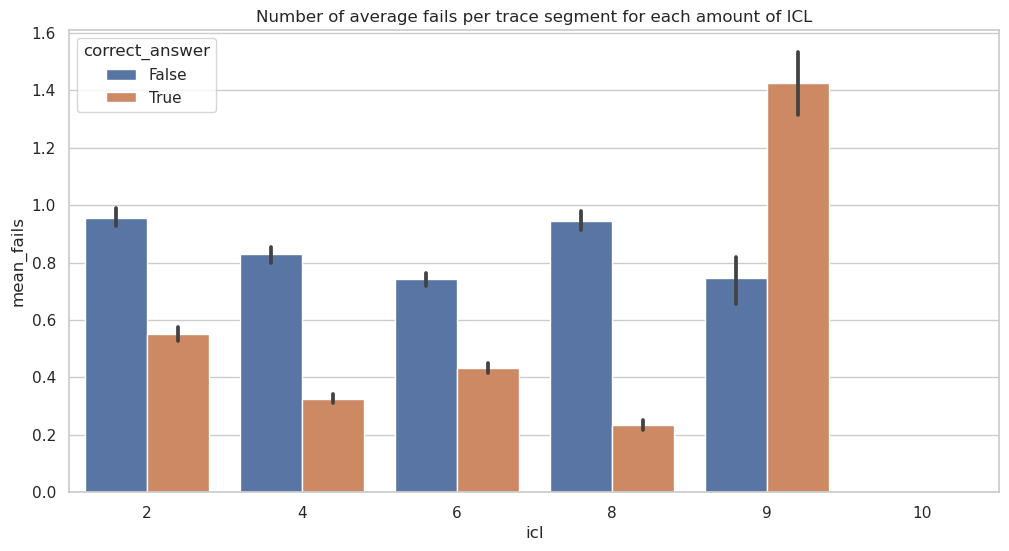

In [73]:
#sort by icl
title = "Number of average fails per trace segment for each amount of ICL"
df = df.sort_values(by='icl')
plot_x_y_per_trace_box(df, outliers=False, y='mean_fails', x='icl', title=title)
# plot_x_y_per_trace_box(df, outliers=True, x='mean_fails')
plot_x_y_per_trace_bar(df, y='mean_fails', x='icl', title=title)
plot_x_y_per_trace_bar(df, y='mean_fails', x='icl', title=title, meta_filter="correct_answer")

In [ ]:
title = "Number of average fails per trace segment for each amount of ICL Model combination"

#group by model
df = df.sort_values(by='file')
plot_x_y_per_trace_box(df, outliers=False, x='mean_fails', y='file', title=title)
# plot_x_y_per_trace_box(df, outliers=True, x='mean_fails')
plot_x_y_per_trace_bar(df, x='mean_fails', y='file', title=title)
plot_x_y_per_trace_bar(df, x='mean_fails', y='file', title=title, meta_filter="correct_answer")

In [ ]:
title = "Number of standard deviation in fails per trace segment for each Model, ICL and the combination"

# plot_x_y_per_trace_box(df, outliers=False, x='std_fails', y='model', title=title)
# plot_x_y_per_trace_box(df, outliers=True, x='max_fails')
plot_x_y_per_trace_bar(df, x='std_fails', y='model', title=title)
plot_x_y_per_trace_bar(df, x='std_fails', y='icl', title=title)
plot_x_y_per_trace_bar(df, x='std_fails', y='file', title=title)



### Code with Trace analysis

In [ ]:
df.model.value_counts()

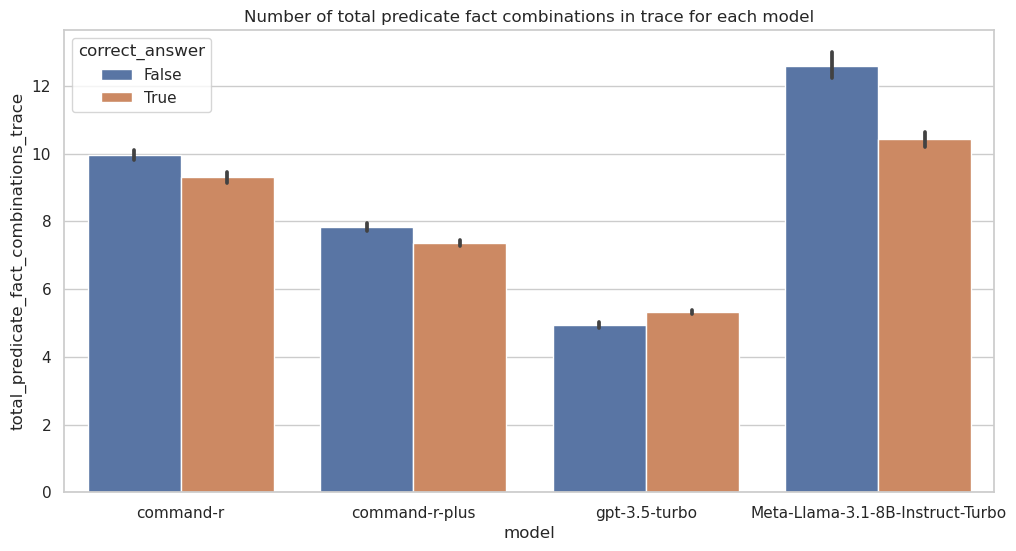

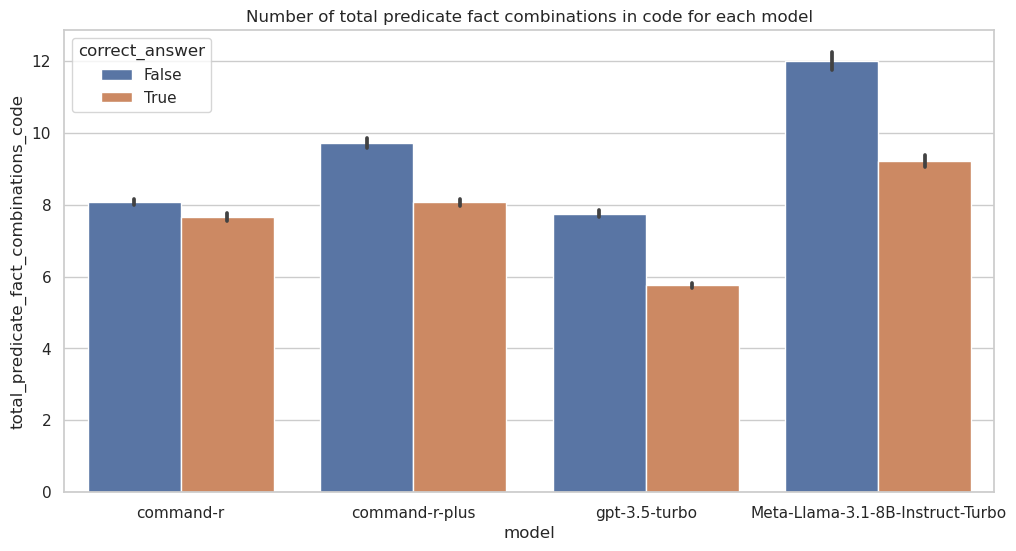

In [75]:
title = "Number of total predicate fact combinations in trace for each model"
plot_x_y_per_trace_bar(df, y='total_predicate_fact_combinations_trace', x='model', title=title, meta_filter="correct_answer")
title = "Number of total predicate fact combinations in code for each model"
plot_x_y_per_trace_bar(df, y='total_predicate_fact_combinations_code', x='model', title=title, meta_filter="correct_answer")


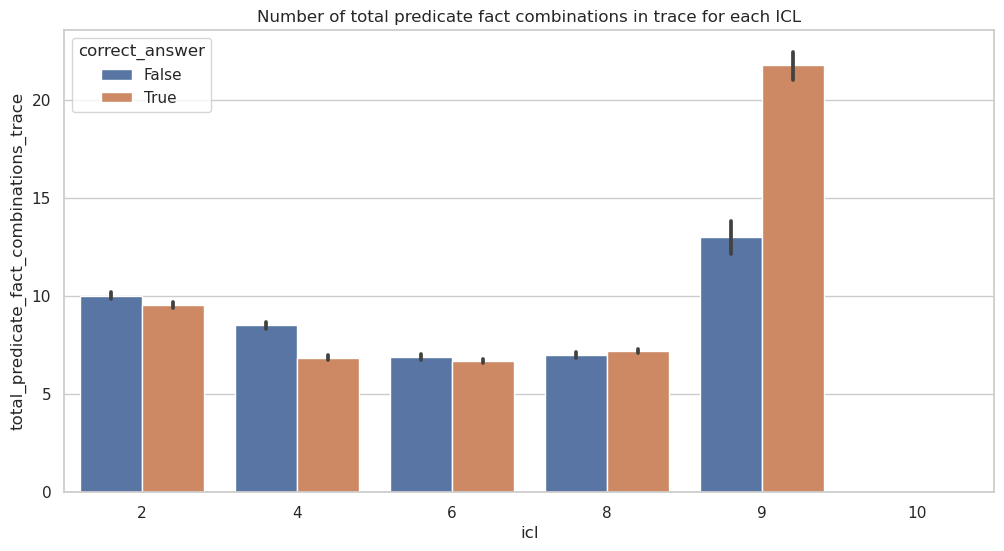

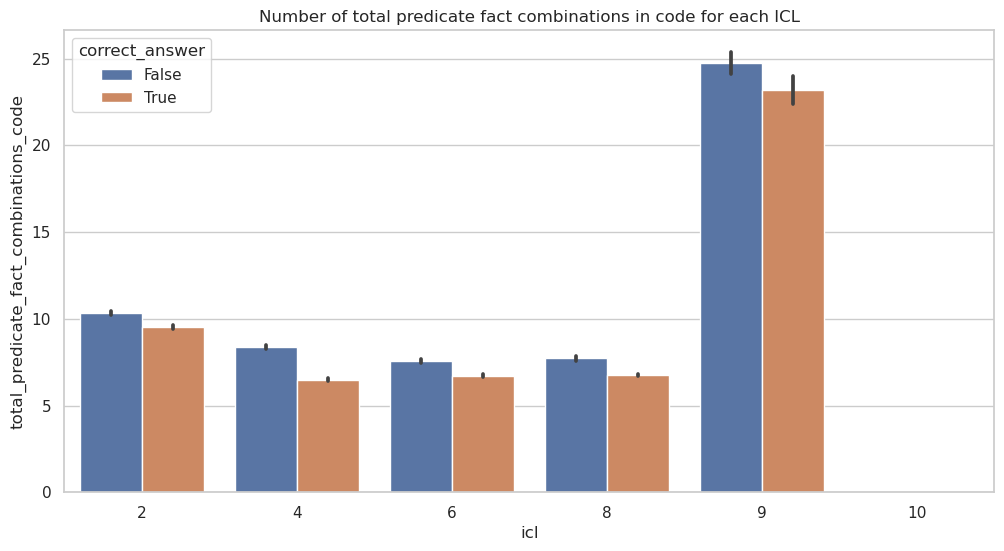

In [77]:
title = "Number of total predicate fact combinations in trace for each ICL"
plot_x_y_per_trace_bar(df, y='total_predicate_fact_combinations_trace', x='icl', title=title, meta_filter="correct_answer")
title = "Number of total predicate fact combinations in code for each ICL"
plot_x_y_per_trace_bar(df, y='total_predicate_fact_combinations_code', x='icl', title=title, meta_filter="correct_answer")

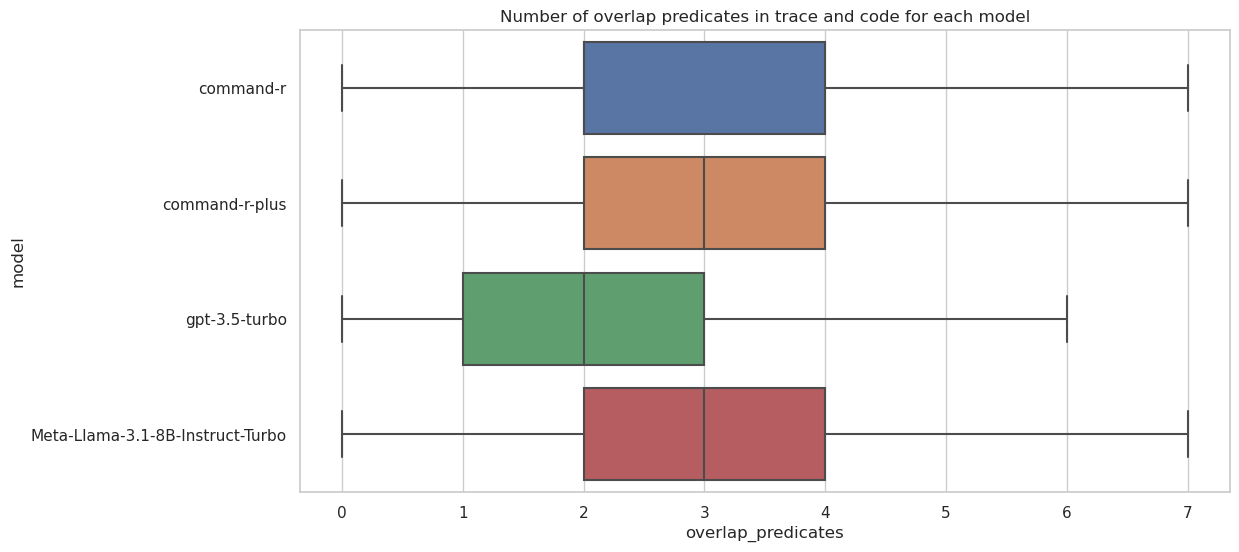

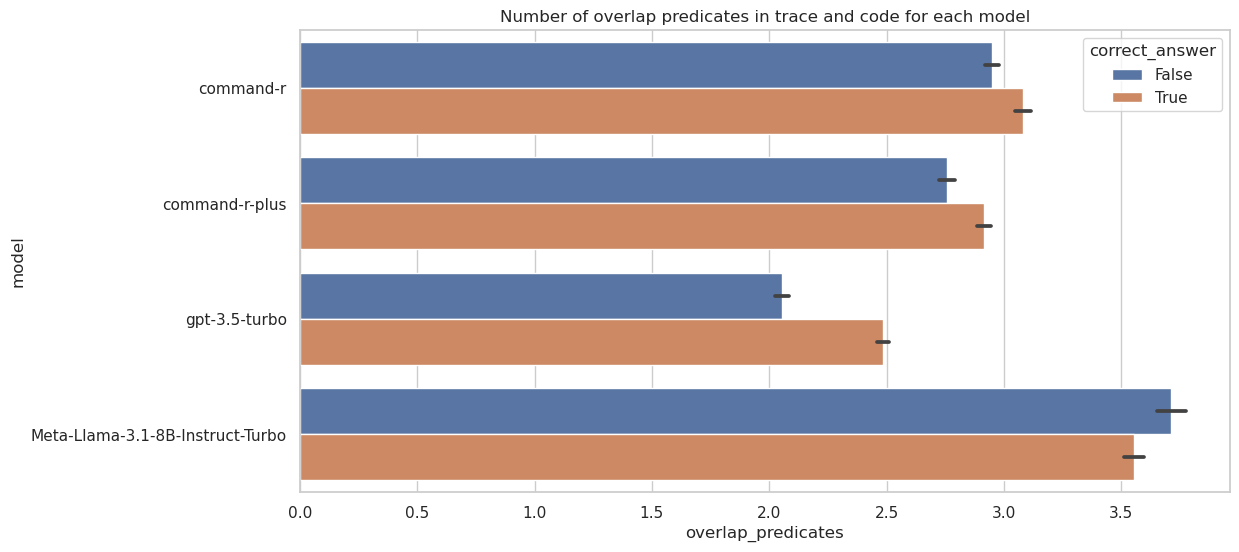

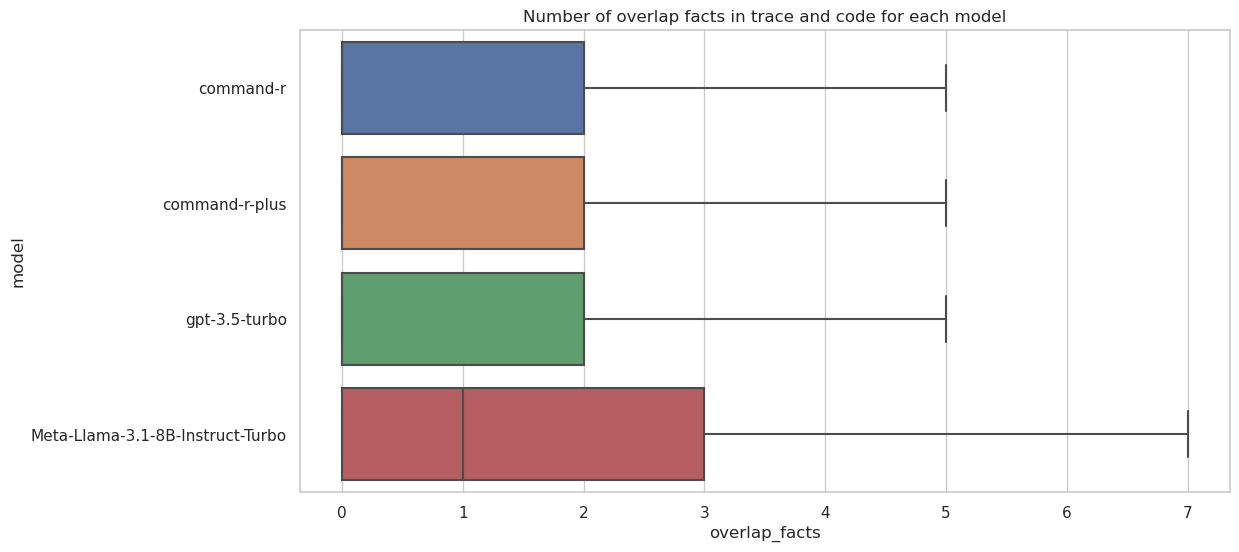

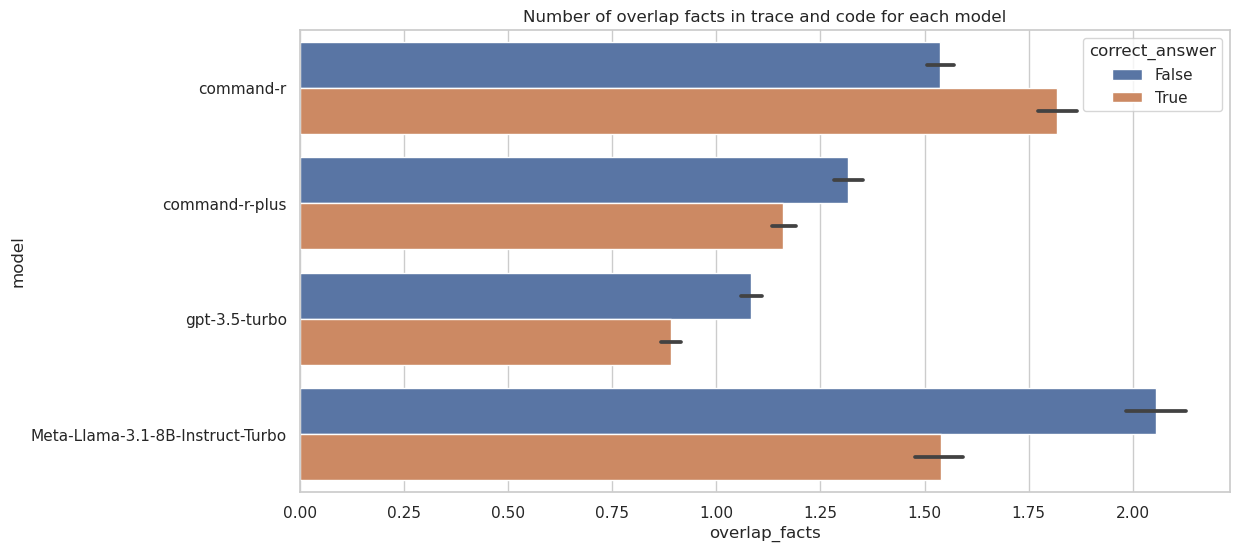

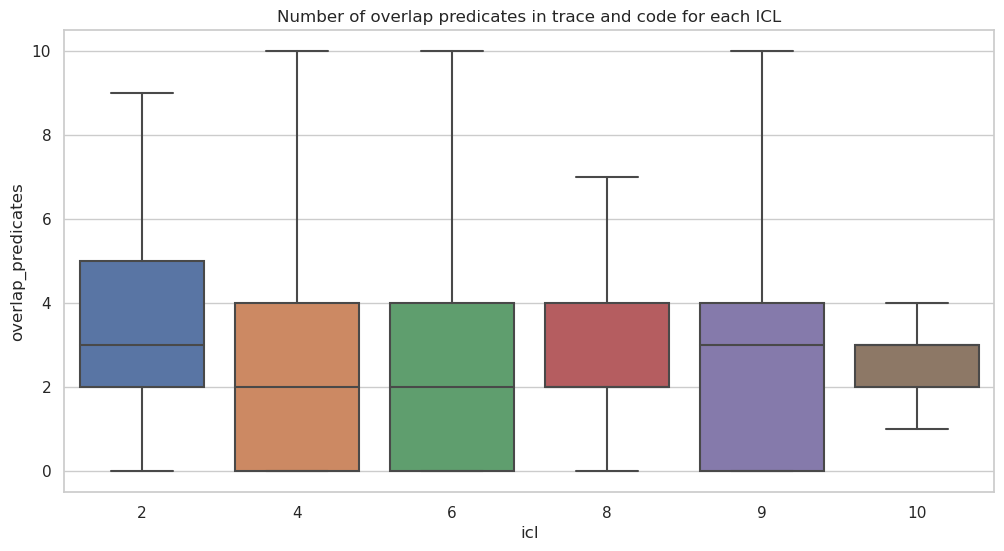

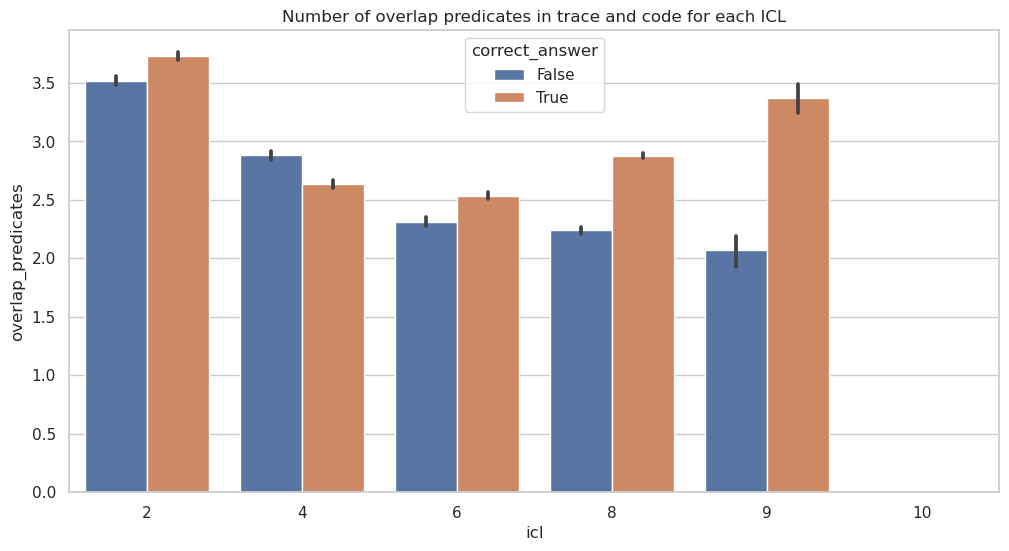

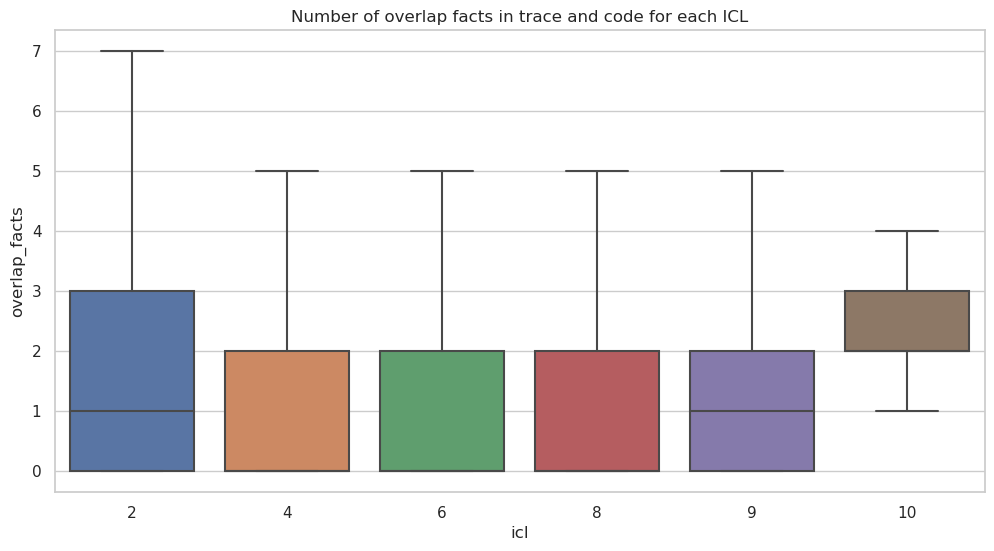

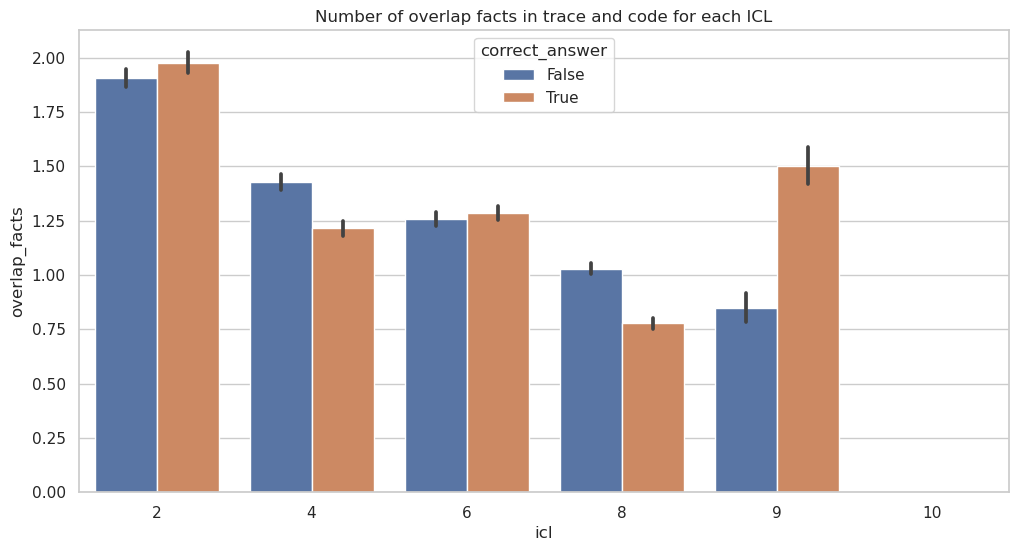

In [80]:
title = "Number of overlap predicates in trace and code for each model"
plot_x_y_per_trace_box(df, x='overlap_predicates', y='model', title=title)
plot_x_y_per_trace_bar(df, x='overlap_predicates', y='model', title=title, meta_filter="correct_answer")
title = "Number of overlap facts in trace and code for each model"
plot_x_y_per_trace_box(df, x='overlap_facts', y='model', title=title)
plot_x_y_per_trace_bar(df, x='overlap_facts', y='model', title=title, meta_filter="correct_answer")

title = "Number of overlap predicates in trace and code for each ICL"
plot_x_y_per_trace_box(df, y='overlap_predicates', x='icl', title=title)
plot_x_y_per_trace_bar(df, y='overlap_predicates', x='icl', title=title, meta_filter="correct_answer")
title = "Number of overlap facts in trace and code for each ICL"
plot_x_y_per_trace_box(df, y='overlap_facts', x='icl', title=title)
plot_x_y_per_trace_bar(df, y='overlap_facts', x='icl', title=title, meta_filter="correct_answer")


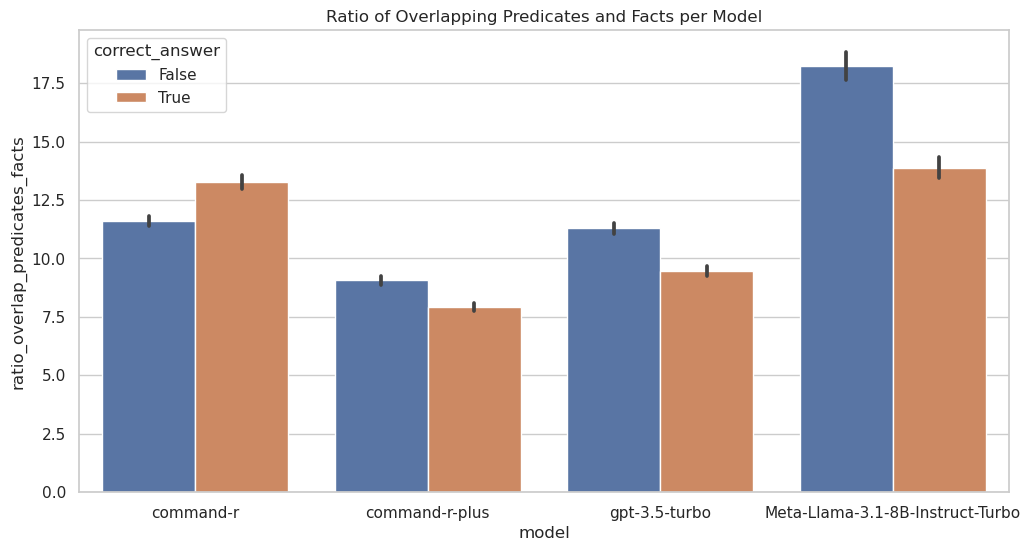

In [83]:
plot_x_y_per_trace_bar(df, y='ratio_overlap_predicates_facts', x='model', title="Ratio of Overlapping Predicates and Facts per Model", meta_filter="correct_answer")


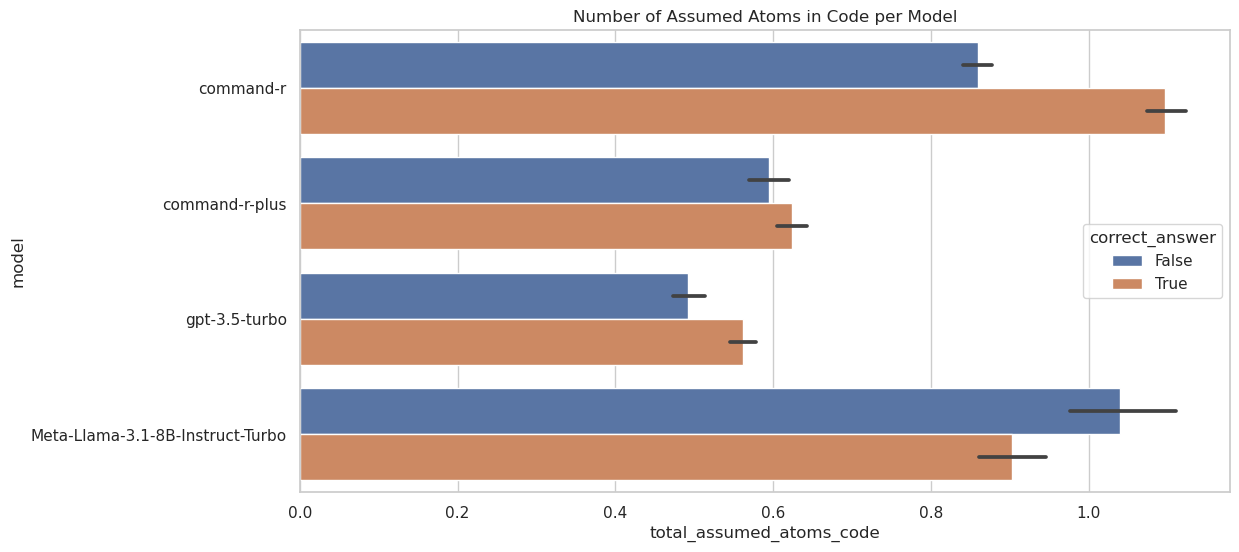

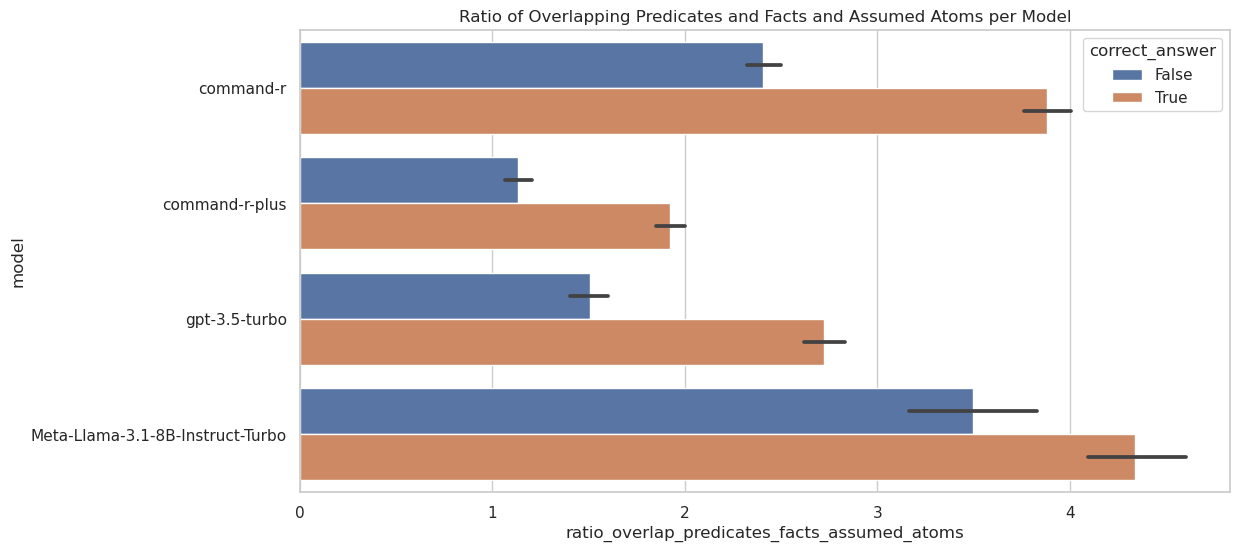

In [82]:
plot_x_y_per_trace_bar(df, x='total_assumed_atoms_code', y='model', title="Number of Assumed Atoms in Code per Model", meta_filter="correct_answer")
plot_x_y_per_trace_bar(df, x='ratio_overlap_predicates_facts_assumed_atoms', y='model', title="Ratio of Overlapping Predicates and Facts and Assumed Atoms per Model", meta_filter="correct_answer")

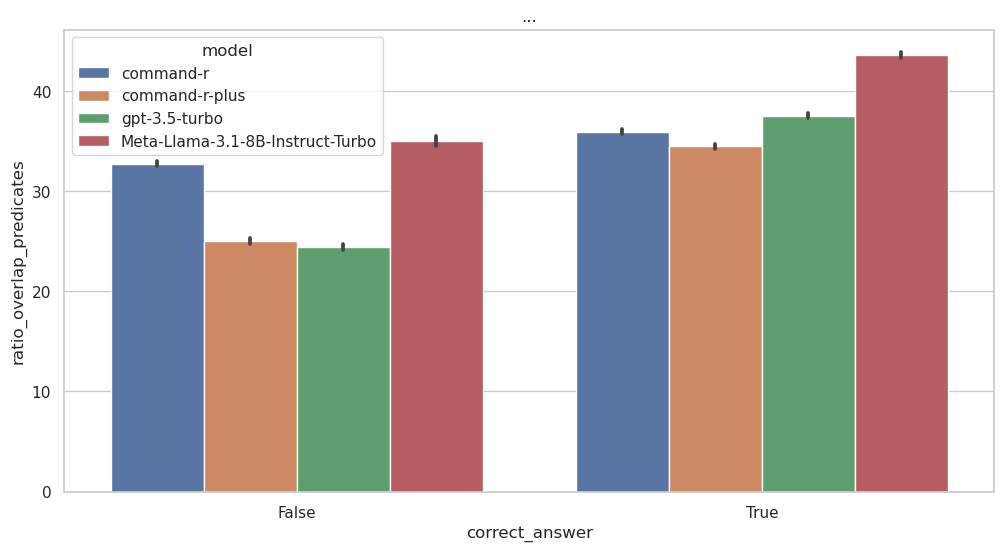

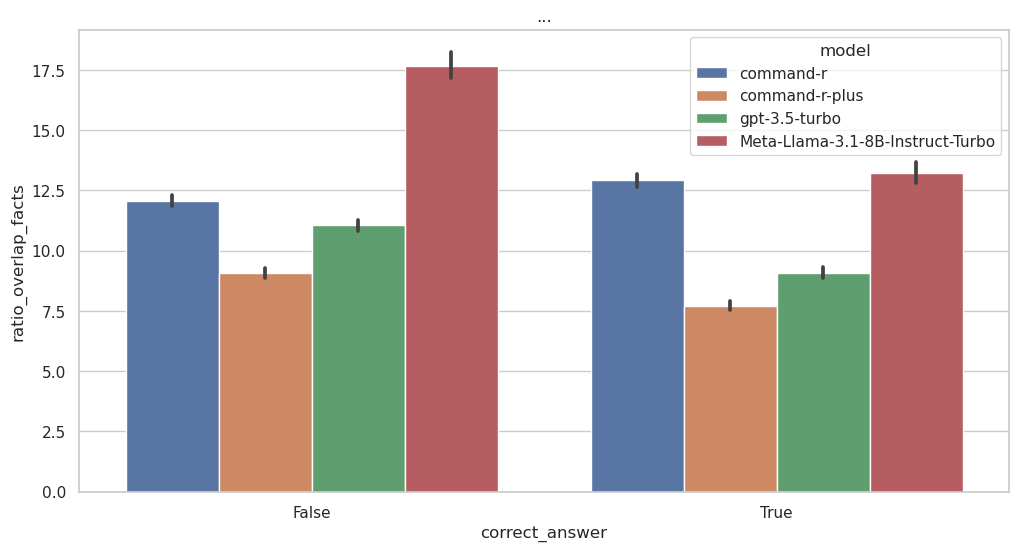

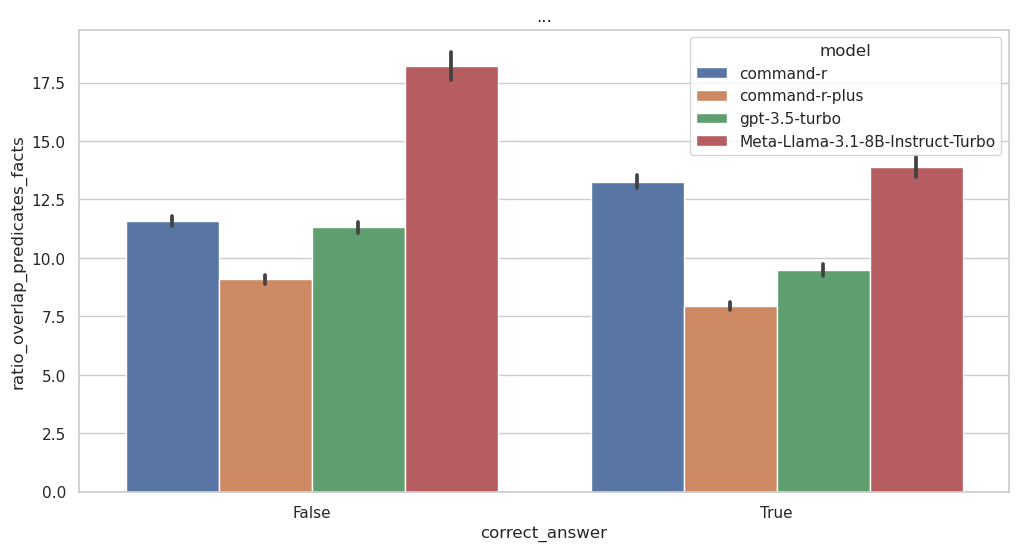

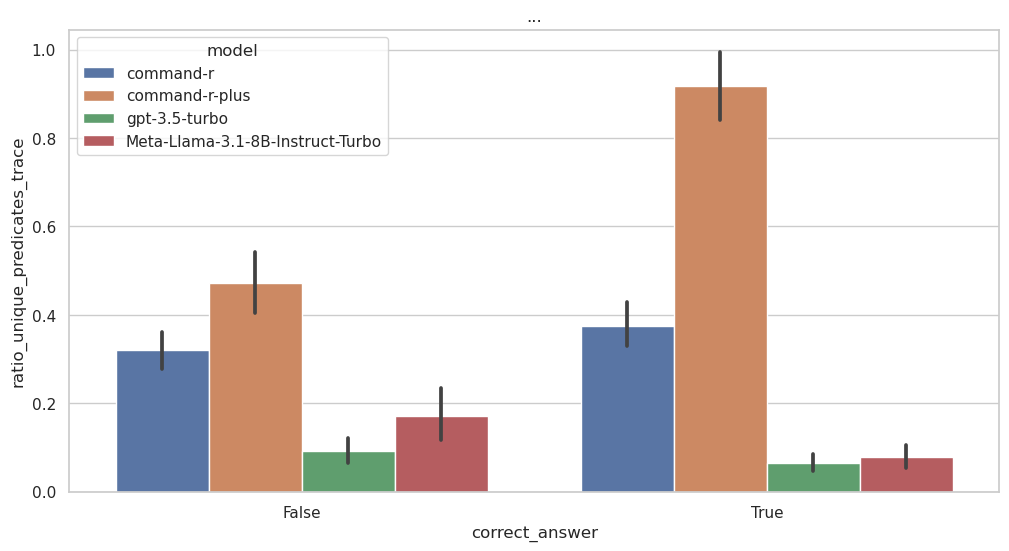

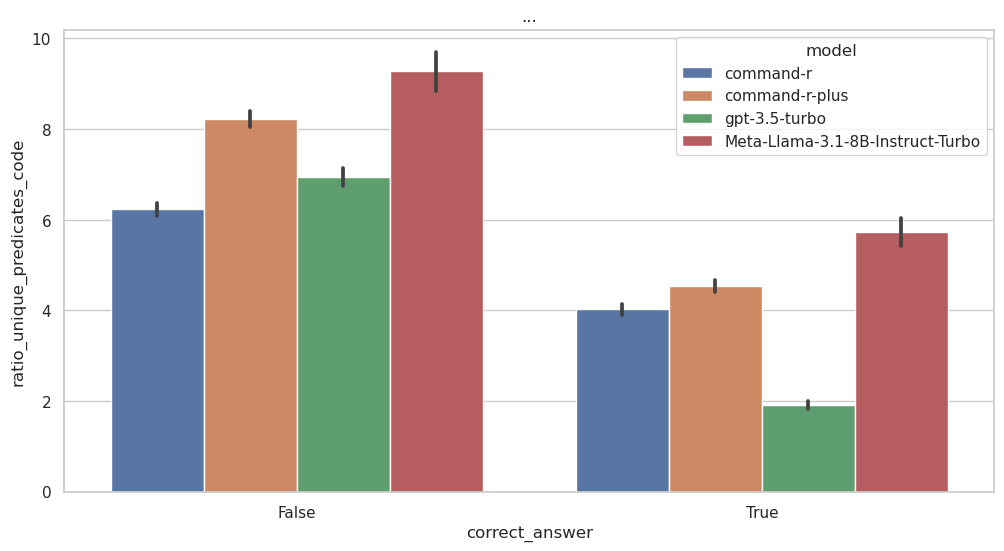

In [84]:
title = "..."
#choose only command-r-plus
# new_df = df[df['model'] == 'gpt-3.5-turbo']

# plot_x_y_per_trace_bar(df, x='correct_answer', y='total_facts_trace', title=title, meta_filter="model")
# plot_x_y_per_trace_bar(df, x='correct_answer', y='total_facts_code', title=title, meta_filter="model")
# plot_x_y_per_trace_bar(df, x='correct_answer', y='total_predicates_trace', title=title, meta_filter="model")
# plot_x_y_per_trace_bar(df, x='correct_answer', y='total_predicates_code', title=title, meta_filter="model")
# plot_x_y_per_trace_bar(df, x='correct_answer', y='total_predicate_fact_combinations_trace', title=title, meta_filter="model")
# plot_x_y_per_trace_bar(df, x='correct_answer', y='total_predicate_fact_combinations_code', title=title, meta_filter="model")
# plot_x_y_per_trace_bar(df, x='correct_answer', y='overlap_predicates', title=title, meta_filter="model")
# plot_x_y_per_trace_bar(df, x='correct_answer', y='overlap_facts', title=title, meta_filter="model")
# plot_x_y_per_trace_bar(df, x='correct_answer', y='unique_predicates_trace', title=title, meta_filter="model")
# plot_x_y_per_trace_bar(df, x='correct_answer', y='unique_predicates_code', title=title, meta_filter="model")
# plot_x_y_per_trace_bar(df, x='correct_answer', y='unique_facts_trace', title=title, meta_filter="model")
# plot_x_y_per_trace_bar(df, x='correct_answer', y='unique_facts_code', title=title, meta_filter="model")
# plot_x_y_per_trace_bar(df, x='correct_answer', y='unique_predicates_facts_combinations_trace', title=title, meta_filter="model")
# plot_x_y_per_trace_bar(df, x='correct_answer', y='unique_predicates_facts_combinations_code', title=title, meta_filter="model")
# plot_x_y_per_trace_bar(df, x='correct_answer', y='attempted_variable_substitutions', title=title, meta_filter="model")
# plot_x_y_per_trace_bar(df, x='correct_answer', y='total_assumed_atoms_code', title=title, meta_filter="model")
# plot_x_y_per_trace_bar(df, x='correct_answer', y='overlap_predicates_assumed_atoms', title=title, meta_filter="model")
# plot_x_y_per_trace_bar(df, x='correct_answer', y='overlap_facts_assumed_atoms', title=title, meta_filter="model")
plot_x_y_per_trace_bar(df, x='correct_answer', y='ratio_overlap_predicates', title=title, meta_filter="model")
plot_x_y_per_trace_bar(df, x='correct_answer', y='ratio_overlap_facts', title=title, meta_filter="model")
plot_x_y_per_trace_bar(df, x='correct_answer', y='ratio_overlap_predicates_facts', title=title, meta_filter="model")
plot_x_y_per_trace_bar(df, x='correct_answer', y='ratio_unique_predicates_trace', title=title, meta_filter="model")
plot_x_y_per_trace_bar(df, x='correct_answer', y='ratio_unique_predicates_code', title=title, meta_filter="model")


### Plot all possible combinations

In [ ]:
from itertools import combinations

def plot_cobinations_distributions(df:pd.DataFrame, combination_columns:List[str], meta_filter:str=None):

    combination_pairs = list(combinations(combination_columns, 2))
    #each figure comes after each combination
    
    for combination in combination_pairs:
        try:
            fig, ax = plt.subplots(1, 1, figsize=(12, 6))

            #if unique values are less more than 10 filter out

            df = df.sort_values(by=combination[0])
            title = f"Distribution of {combination[0]} and {combination[1]}"
            if meta_filter is None:
                sns.barplot(df, x=combination[0], y=combination[1], ax=ax)
            else:
                sns.barplot(df, x=combination[0], y=combination[1], ax=ax, hue=meta_filter)
            ax.set_title(title)
            #45 degree rotation
            plt.xticks(rotation=45)
            plt.show()
        

        except Exception as e:
            print(f"Could not plot combination: {combination}")
            print(e)


plot_cobinations_distributions(df, ['num_paths', 'mean_calls', 'mean_fails'], meta_filter="correct_answer")

In [ ]:
plot_cobinations_distributions(df, ['total_predicate_fact_combinations_trace', 'total_predicate_fact_combinations_code'], meta_filter="correct_answer")

In [ ]:
plot_cobinations_distributions(df, ['correct_answer','overlap_predicates', 'overlap_facts'], meta_filter="model")
plot_cobinations_distributions(df, ['correct_answer','unique_predicates_trace', 'unique_predicates_code'], meta_filter="model")


In [ ]:
# plot_cobinations_distributions(df, ['total_predicates_code', 'overlap_predicates'])
# plot_cobinations_distributions(df, ['total_facts_code', 'overlap_facts'])
# plot_cobinations_distributions(df, ['total_predicates_trace', 'unique_predicates_trace'], meta_filter="correct_answer")
# plot_cobinations_distributions(df, ['total_facts_trace', 'unique_facts_trace'], meta_filter="correct_answer")
# plot_cobinations_distributions(df, ['total_predicates_code', 'unique_predicates_code'], meta_filter="correct_answer")